In [1]:
from numpy import mean, std, average
import matplotlib.pyplot as plt 
from copy import deepcopy
import numpy as np
import networkx as nx

# MSR - mean subsequence reduce

In [2]:
def msr_consensus(x0, adj_matrix, max_iterations=30, f=0, attck_vals={}):
    """
    Mean-Subsequence-Reduce (MSR) Consensus Algorithm.

    Parameters:
    - x0: Initial state values (list or numpy array).
    - adj_matrix: 2D list representing the adjacency matrix.
    - max_iterations: Number of iterations to run the consensus algorithm.
    - f: Number of outliers to remove from each agent's neighborhood in each iteration.
    - attck_vals: Dictionary with faulty agents as keys and functions for faulty values over time as values


    Returns:
    - x_vals: List of state vectors over iterations.
    """

    num_agents = len(x0)
    x_vals = [np.array(x0)]  # list to store state vectors over iterations
    neighbors = [[j for j in range(num_agents) if adj_matrix[i][j]] for i in range(num_agents)]

    for a in attck_vals: x_vals[-1][a] = attck_vals[a](0)

    for k in range(max_iterations):
        x_new = np.zeros(num_agents)
        
        for i in range(num_agents):
            # Get current values of neighbors
            neighbor_vals = np.array([x_vals[-1][j] for j in neighbors[i]] + [x_vals[-1][i]])
            # Sort values and remove the f smallest and f largest if possible
            sorted_vals = np.sort(neighbor_vals)
            if f and len(sorted_vals) > 2 * f:
                filtered_vals = sorted_vals[f:-f]
            else:
                filtered_vals = sorted_vals  # If not enough values, take all

            # Take the mean of the filtered values
            x_new[i] = np.mean(filtered_vals)

            for a in attck_vals: x_new[a] = attck_vals[a](i+1)

        x_vals.append(x_new.copy())

    return x_vals

# Reputation-based

In [122]:
def repBasedConsensus(x0, adjacency_matrix, max_iterations=30, f=0, attck_vals={}):
    """
    Reputation-based Consensus (RepB) Algorithm.

    Parameters:
    - x0: Initial state values (list or numpy array).
    - adj_matrix: 2D list representing the adjacency matrix.
    - max_iterations: Number of iterations to run the consensus algorithm.
    - f: Number of outliers to remove from each agent's neighborhood in each iteration.
    - attck_vals: Dictionary with faulty agents as keys and functions for faulty values over time as values

    Returns:
    - r: List of state vectors over iterations.
    """
    n = len(x0)
    ns = [0]*n
    x = x0[:]
    r = [x0.copy()]
    for a in attck_vals:
        x[a] = attck_vals[a](0)
        r[-1][a] = x[a]
    for i in range(1,max_iterations):
        for j in range(n):
            ngs = [k for k in range(n) if adjacency_matrix[k][j]]
            rps = []
            for k in ngs:
                rps += [(lambda z:sum(z)/len(z))([abs(x[l]-x[k]) for l in ngs+[j]])]
            order = (lambda z:z[:-f] if f > 0 else z)(sorted(range(len(rps)), key=lambda z: rps[z]))
            s = x[j] + sum([x[ngs[k]] for k in order])
            s = s/(1+len(order))
            x[j] = s
        for a in attck_vals:
            x[a] = attck_vals[a](i+1)
        r += [x.copy()]
    return r

# Agent-agnostic

In [169]:
def consensus(x0, adj_mat, attck_vals={}, nit=10):
    """
    Agent-agnostic Consensus (AA) Algorithm.

    Parameters:
    - x0: Initial state values (list or numpy array).
    - adj_matrix: 2D list representing the adjacency matrix.
    - nit: Number of iterations to run the consensus algorithm.
    - attck_vals: Dictionary with faulty agents as keys and functions for faulty values over time as values

    Returns:
    - r: List of state vectors over iterations.
    """
    neigh = [[j for j in range(len(adj_mat)) if adj_mat[i][j]] for i in range(len(adj_mat))]
    r = [x0]
    adj = adj_mat 
    for j in attck_vals:
        r[-1][j] = attck_vals[j](0)
    for k in range(1, nit-1):
        x = []
        for i in range(len(adj)):
            if i in attck_vals:
                x.append(attck_vals[i](k))
            else:
                x_pred = r[-1]
                vals = neigh[i]
                x_s = [x_pred[j] for j in vals]+[x_pred[i]]
                mu = mean(x_s)
                s = std(x_s)

                filtration = []
                while k > 1 and len(vals) > 1 and filtration != vals:
                    filtration = vals[:]
                    tmp = list(filter(lambda j: abs(x_pred[j]-mu) <= s, vals))
                    if len(tmp):
                        vals = tmp[:]
                        x_s = [x_pred[j] for j in vals]+[x_pred[i]]
                        mu = mean(x_s)
                        s = std(x_s)
                    else:
                        filtration = [min(vals, key=lambda j:abs(x_pred[j]-mu))]
                        break

                x_s = [x_pred[j] for j in vals]+[x_pred[i]]
                x.append(mean(x_s))


        r.append(x)
    return r

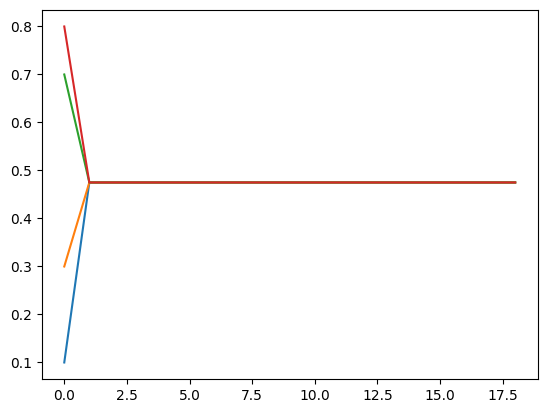

In [150]:
x0 = [.1,.3,.7,.8]
adjacency_matrix = [[0,1,1,1],[1,0,1,1],[1,1,0,1],[1,1,1,0]]

r=consensus(x0,adjacency_matrix, nit=20)

plt.plot(list(range(len(r))),list(r))
plt.show()

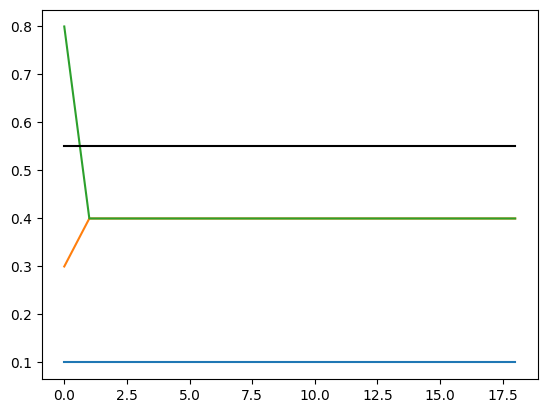

In [151]:
adj3 = [[0,1,1],[1,0,1],[1,1,0]]
x3 = [.1,.3,.8]
att_v3 = {0:(lambda x:0.1)}
r = consensus(x3,adj3, attck_vals=att_v3, nit=20)
true_val = (sum(x3)-sum(list(map(lambda f:f(0), att_v3.values()))))/(len(x3)-len(att_v3))
plt.plot(list(range(len(r))),list(r))
plt.plot([0,len(r)-1], [true_val, true_val],color="black")
plt.show()

## Agent-agnostic

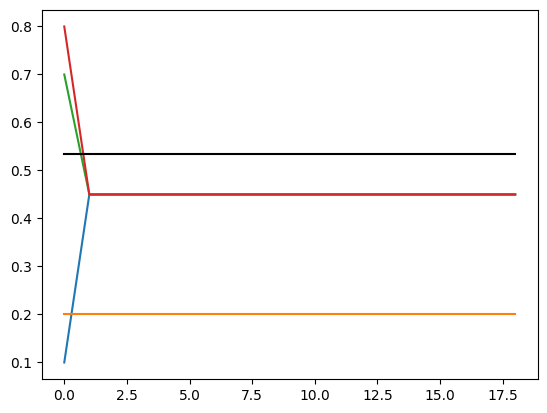

In [152]:
att_v = {1:(lambda x:0.2)}
r = consensus(x0,adjacency_matrix, attck_vals=att_v, nit=20)
true_val = (sum(x0)-sum(list(map(lambda f:f(0), att_v.values()))))/(len(x0)-len(att_v))
plt.plot(list(range(len(r))),list(r))
plt.plot([0,len(r)-1], [true_val, true_val],color="black")
plt.show()

## Reputation-based

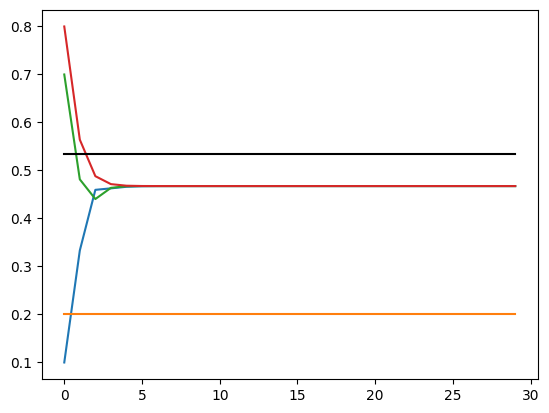

In [13]:
att_v = {1:(lambda x:0.2)}
r=repBasedConsensus(x0, adjacency_matrix, f=1, attck_vals=att_v)
true_val = (sum(x0)-sum(list(map(lambda f:f(0), att_v.values()))))/(len(x0)-len(att_v))
plt.plot(list(range(len(r))),list(r))
plt.plot([0,len(r)-1], [true_val, true_val],color="black")
plt.show()

## MSR

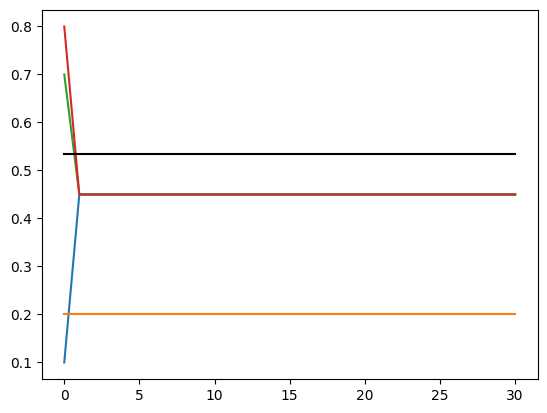

In [14]:
att_v = {1:(lambda x:0.2)}
r = msr_consensus(x0, adjacency_matrix, attck_vals=att_v, f=1)
true_val = (sum(x0)-sum(list(map(lambda f:f(0), att_v.values()))))/(len(x0)-len(att_v))
plt.plot(list(range(len(r))),list(r))
plt.plot([0,len(r)-1], [true_val, true_val],color="black")
plt.show()

In [396]:
mean([x0[0]]+x0[2:])

0.5333333333333333

## Agent agnostic

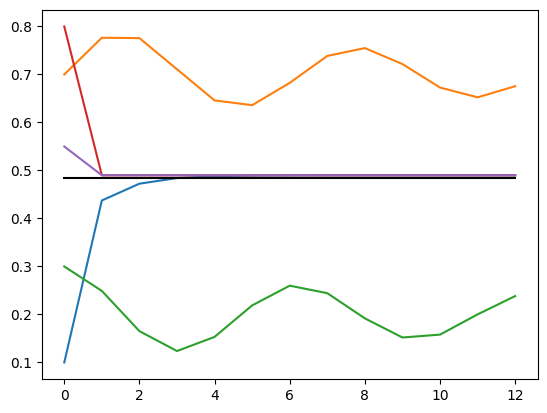

In [98]:
from math import sin, cos
att_v = {1:(lambda x:0.7+1/(x+10)*sin(x)), 2:(lambda x:0.2+1/(x+10)*cos(x))}
xInit = x0+[.55]
res=consensus(xInit,[[0, 0, 1, 1, 1], [0, 0, 1, 1, 1], [1, 1, 0, 1, 1], \
                                 [1, 1, 1, 0,1],[1, 1, 1, 1, 0]],\
                                   attack_vals=att_v, nit=20)
true_val = (sum(xInit)-sum(list(map(lambda f:f(0), att_v.values()))))/(len(xInit)-len(att_v))
plt.plot(list(range(len(res))),list(res))
plt.plot([0,len(res)-1], [true_val, true_val],color="black")
plt.show()

## Reputation-based

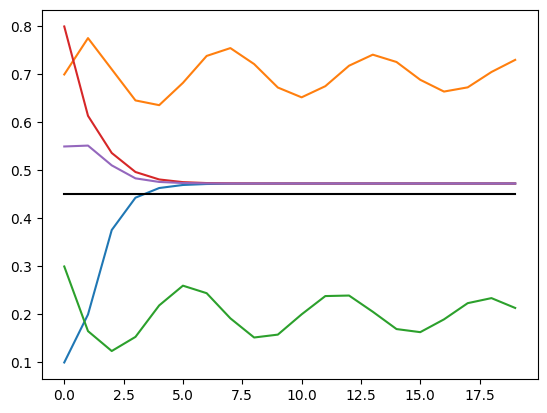

In [16]:
from math import sin, cos
att_v = {1:(lambda x:0.7+1/(x+10)*sin(x)), 2:(lambda x:0.2+1/(x+10)*cos(x))}
xInit = x0+[.55]
res=repBasedConsensus(xInit,[[0, 0, 1, 1, 1], [0, 0, 1, 1, 1], [1, 1, 0, 1, 1], \
                                 [1, 1, 1, 0,1],[1, 1, 1, 1, 0]], f=2,\
                                   attck_vals=att_v, max_iterations=20)
true_val = (sum(xInit)-sum(list(map(lambda f:f(0), att_v.values()))))/(len(xInit)-len(att_v))
plt.plot(list(range(len(res))),list(res))
plt.plot([0,len(res)-1], [true_val, true_val],color="black")
plt.show()

## MSR

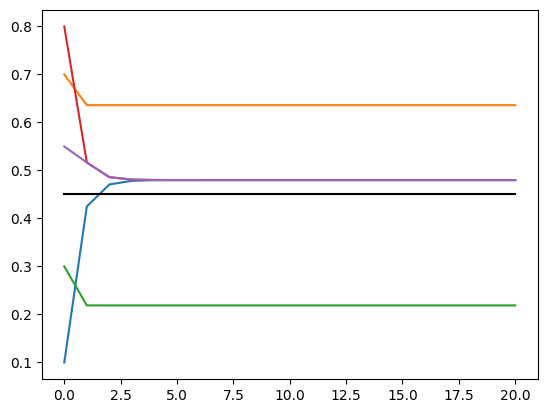

In [18]:
from math import sin, cos
att_v = {1:(lambda x:0.7+1/(x+10)*sin(x)), 2:(lambda x:0.2+1/(x+10)*cos(x))}
xInit = x0+[.55]
res=msr_consensus(xInit,[[0, 0, 1, 1, 1], [0, 0, 1, 1, 1], [1, 1, 0, 1, 1], \
                                 [1, 1, 1, 0,1],[1, 1, 1, 1, 0]], f=1,\
                                   attck_vals=att_v, max_iterations=20)
true_val = (sum(xInit)-sum(list(map(lambda f:f(0), att_v.values()))))/(len(xInit)-len(att_v))
plt.plot(list(range(len(res))),list(res))
plt.plot([0,len(res)-1], [true_val, true_val],color="black")
plt.show()

In [407]:
mean([x0[0]]+(x0+[.55])[3:])

0.4833333333333334

## Agent-agnostic

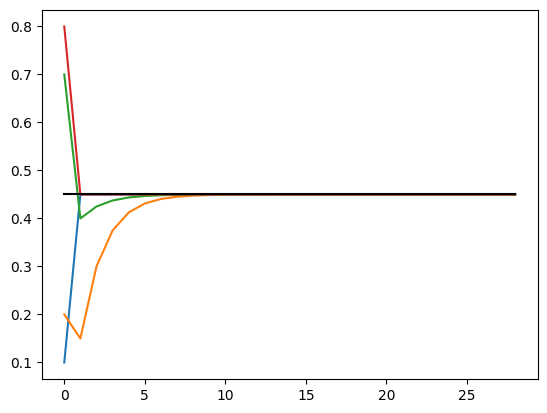

In [128]:
att_v = {}
xInit = x0[:4]

res=consensus(xInit,[[0,1,1,1],[1,0,0,0],[1,0,0,0],[1,0,0,0]], nit=30)
true_val = (sum(xInit)-sum(list(map(lambda f:f(0), att_v.values()))))/(len(xInit)-len(att_v))
plt.plot(list(range(len(res))),list(res))
plt.plot([0,len(res)-1], [true_val, true_val],color="black")
plt.show()

## Consensus-based

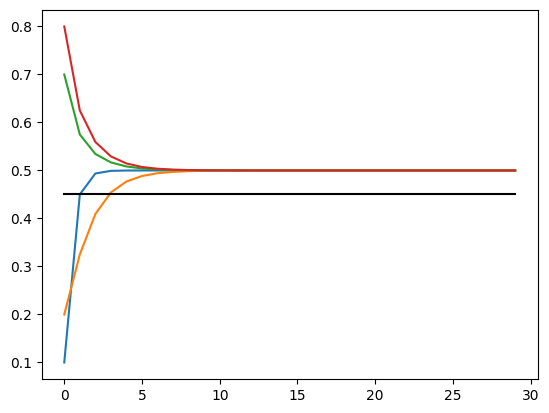

In [20]:
att_v = {}
xInit = x0[:4]

res=repBasedConsensus(xInit,[[0,1,1,1],[1,0,0,0],[1,0,0,0],[1,0,0,0]], max_iterations=30)
true_val = (sum(xInit)-sum(list(map(lambda f:f(0), att_v.values()))))/(len(xInit)-len(att_v))
plt.plot(list(range(len(res))),list(res))
plt.plot([0,len(res)-1], [true_val, true_val],color="black")
plt.show()

## MSR

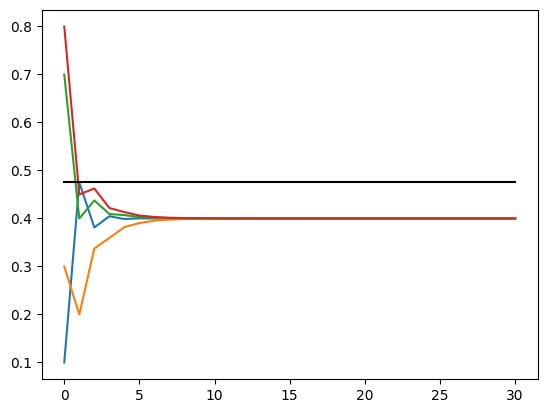

In [100]:
att_v = {}
xInit = x0[:4]

res=msr_consensus(xInit,[[0,1,1,1],[1,0,0,0],[1,0,0,0],[1,0,0,0]], max_iterations=30)
true_val = (sum(xInit)-sum(list(map(lambda f:f(0), att_v.values()))))/(len(xInit)-len(att_v))
plt.plot(list(range(len(res))),list(res))
plt.plot([0,len(res)-1], [true_val, true_val],color="black")
plt.show()

In [418]:
mean(x0[:4])

0.45

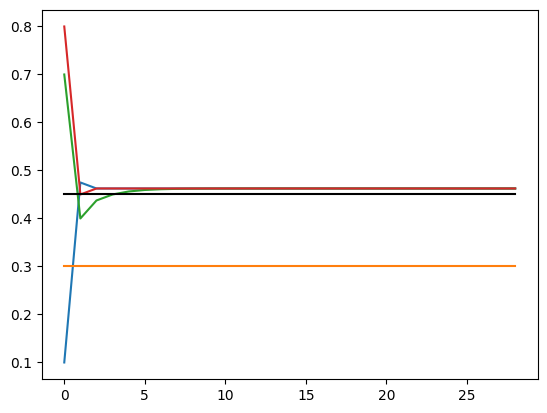

In [129]:
res=consensus(x0[:4],[[0,1,1,1],[1,0,0,0],[1,0,0,0],[1,0,0,0]],
              attck_vals={1:(lambda x:0.3)}, nit=30)
true_val = (sum(xInit)-sum(list(map(lambda f:f(0), att_v.values()))))/(len(xInit)-len(att_v))
plt.plot(list(range(len(res))),list(res))
plt.plot([0,len(res)-1], [true_val, true_val],color="black")
plt.show()

## Agent-agnostic

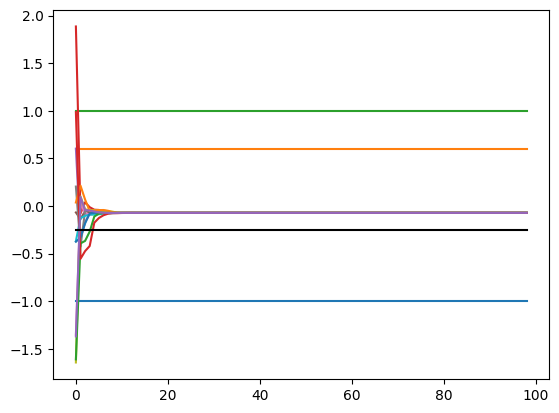

In [130]:
adj_matrix = [[0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0], [1, 0, 0, 1, 1, 1, 1, 
  0, 1, 0, 1, 1, 0, 0, 1], [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 
  0], [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1], [1, 1, 0, 1, 0, 
  1, 1, 1, 1, 1, 0, 1, 1, 0, 1], [0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 
  0, 0, 1], [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0], [0, 0, 1, 
  0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1], [1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 
  1, 0, 0, 0, 0], [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0], [0, 
  1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1], [1, 1, 0, 1, 1, 0, 0, 0, 
  0, 0, 0, 0, 1, 1, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 
  1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1], [0, 1, 0, 1, 1, 
  1, 0, 1, 0, 0, 1, 0, 1, 1, 0]]
xInit = [-1.04694, -0.00216506, -0.897521, 1.88615, 0.603284, -0.0669066, \
-1.35135, 0.20474, -1.64277, -0.367927, -0.374351, 0.0373047, \
-1.61005, 0.985223, -1.36896]
att_v = {0:(lambda x:-1.),1:(lambda x:0.6),2:(lambda x:1)}

res=consensus(xInit,adj_matrix, attck_vals=att_v,nit=100)
true_val = (sum(xInit)-sum(list(map(lambda f:f(0), att_v.values()))))/(len(xInit)-len(att_v))
plt.plot(list(range(len(res))),list(res))
plt.plot([0,len(res)-1], [true_val, true_val],color="black")
plt.show()

## Reputation-based

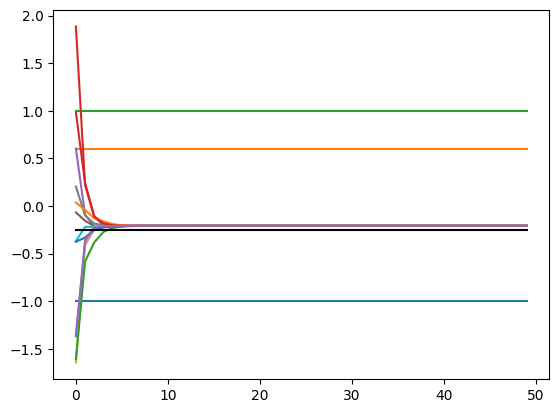

In [131]:
res=repBasedConsensus(xInit, adj_matrix,attck_vals=att_v, f=3, max_iterations=50)
true_val = (sum(xInit)-sum(list(map(lambda f:f(0), att_v.values()))))/(len(xInit)-len(att_v))
plt.plot(list(range(len(res))),list(res))
plt.plot([0,len(res)-1], [true_val, true_val],color="black")
plt.show()

## MSR

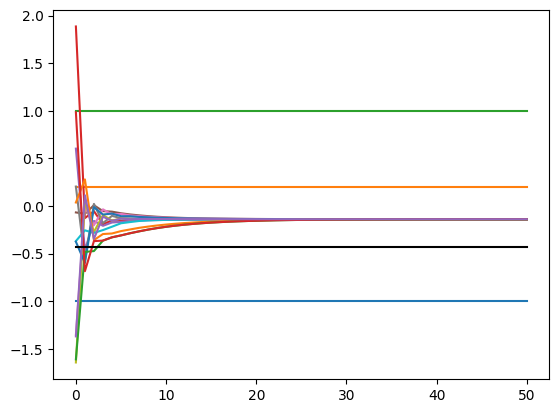

In [132]:
adj_matrix = [[0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0], [1, 0, 0, 1, 1, 1, 1, 
  0, 1, 0, 1, 1, 0, 0, 1], [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 
  0], [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1], [1, 1, 0, 1, 0, 
  1, 1, 1, 1, 1, 0, 1, 1, 0, 1], [0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 
  0, 0, 1], [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0], [0, 0, 1, 
  0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1], [1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 
  1, 0, 0, 0, 0], [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0], [0, 
  1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1], [1, 1, 0, 1, 1, 0, 0, 0, 
  0, 0, 0, 0, 1, 1, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 
  1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1], [0, 1, 0, 1, 1, 
  1, 0, 1, 0, 0, 1, 0, 1, 1, 0]]
xInit = [-1.04694, -0.00216506, -0.897521, 1.88615, 0.603284, -0.0669066, \
-1.35135, 0.20474, -1.64277, -0.367927, -0.374351, 0.0373047, \
-1.61005, 0.985223, -1.36896]
att_v = {0:(lambda x:-1.),1:(lambda x:0.2),2:(lambda x:1)}

res=msr_consensus(xInit, adj_matrix,attck_vals=att_v, f=2, max_iterations=50)
true_val = (sum(xInit)-sum(list(map(lambda f:f(0), att_v.values()))))/(len(xInit)-len(att_v))
plt.plot(list(range(len(res))),list(res))
plt.plot([0,len(res)-1], [true_val, true_val],color="black")
plt.show()

## Agent-agnostic

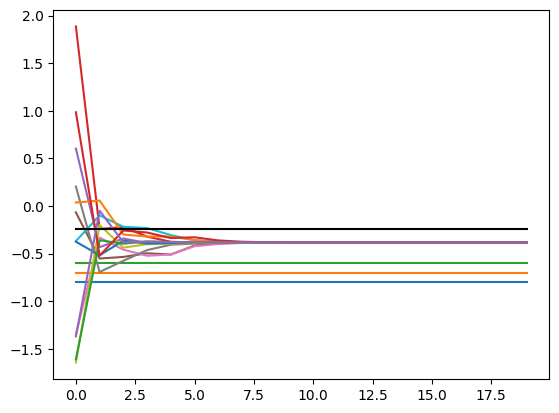

In [104]:
adj_matrix = [[0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0], [1, 0, 0, 1, 1, 1, 1, 
  0, 1, 0, 1, 1, 0, 0, 1], [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 
  0], [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1], [1, 1, 0, 1, 0, 
  1, 1, 1, 1, 1, 0, 1, 1, 0, 1], [0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 
  0, 0, 1], [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0], [0, 0, 1, 
  0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1], [1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 
  1, 0, 0, 0, 0], [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0], [0, 
  1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1], [1, 1, 0, 1, 1, 0, 0, 0, 
  0, 0, 0, 0, 1, 1, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 
  1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1], [0, 1, 0, 1, 1, 
  1, 0, 1, 0, 0, 1, 0, 1, 1, 0]]
xInit = [-1.04694, -0.00216506, -0.897521, 1.88615, 0.603284, -0.0669066, \
-1.35135, 0.20474, -1.64277, -0.367927, -0.374351, 0.0373047, \
-1.61005, 0.985223, -1.36896]
att_v = {0:(lambda x:-.8),1:(lambda x:-.7),2:(lambda x:-.6)}

res=consensus(xInit, adj_matrix, attack_vals=att_v,nit=100)
true_val = (sum(xInit)-sum(list(map(lambda f:f(0), att_v.values()))))/(len(xInit)-len(att_v))
plt.plot(list(range(len(res))),list(res))
plt.plot([0,len(res)-1], [true_val, true_val],color="black")
plt.show()

## Reputation-based

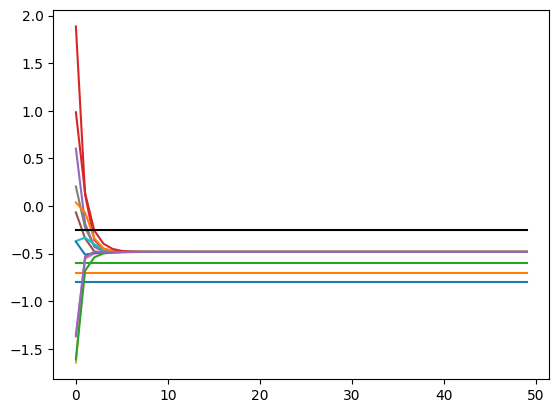

In [29]:
res=repBasedConsensus(xInit, adj_matrix,attck_vals=att_v, f=3, max_iterations=50)
true_val = (sum(xInit)-sum(list(map(lambda f:f(0), att_v.values()))))/(len(xInit)-len(att_v))
plt.plot(list(range(len(res))),list(res))
plt.plot([0,len(res)-1], [true_val, true_val],color="black")
plt.show()

## MSR

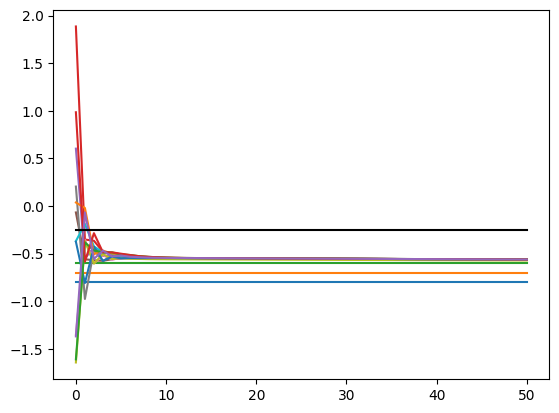

In [31]:
res=msr_consensus(xInit, adj_matrix,attck_vals=att_v, f=2, max_iterations=50)
true_val = (sum(xInit)-sum(list(map(lambda f:f(0), att_v.values()))))/(len(xInit)-len(att_v))
plt.plot(list(range(len(res))),list(res))
plt.plot([0,len(res)-1], [true_val, true_val],color="black")
plt.show()

# Code to transform consensus output *list* to *tikz* plot

In [ ]:
def plot_to_tikz(w, expected=None, title='Consensus evolution'):
    s = "\\begin{tikzpicture}[scale=0.8]\n"+\
        "\\begin{axis}[\n"+\
        "title={"+title+"},\n"+\
        "xlabel={Time},\n"+\
        "ylabel={Agents evolution},\n"+\
        "ylabel shift=-1pt,\n"+\
        "xlabel shift=-1pt,\n"+\
        "xmin=0, xmax="+str(len(w[0])-1)+",\n"+\
        "ymin="+str(min([min(el) for el in w]))+", ymax="+str(max([max(el) for el in w]))+",\n"+\
        "yticklabel style={/pgf/number format/.cd,fixed,precision=4},\n"+\
        "legend pos=north west,\n"+\
        "ymajorgrids=true,\n"+\
        "xmajorgrids=true,\n"+\
        "grid style=dashed,\n"+\
        "scale only axis=true,\n"+\
        "width=0.7\\columnwidth,\n"+\
        "height=0.45\\columnwidth,\n"+\
        "legend style={at={(1.25,.86)},anchor=north,legend cell align=left},\n"+\
        "legend columns=1,\n"+\
        "]\n"
    for i,el in enumerate(w):
        s += "\\addplot[color=c"+str(i+1)+",very thick]\n"+\
            "coordinates {"+reduce(lambda r,i:r+str((i,round(el[i],4))),range(len(el)),'')+'};\n'
    if expected != None:
        val = str(expected)
        s += "\\addplot[color=black, very thick]\n"+\
            "coordinates {(0,"+val+')('+str(len(w[0])-1)+','+val+')};\n'
    s += "\\legend{"+ reduce(lambda r,i:r+"$x_{"+str(i+1)+"}(t)$,",range(len(w)),'')+"}\n"
    s += "\\end{axis}\n"+\
            "\\end{tikzpicture}"
    return s

# Large-scale networks - 1000 nodes

In [205]:
from random import random
x0 = list(10*random() for i in range(1000))
edges = [(1,3), (1,182), (1,420), (1,430), (1,667), (1,703), (1,709), (1,770), (1,812), (1,841), (1,907), (2,25), (2,50), (2,53), (2,73), (2,99), (2,155), (2,235), (2,266), (2,286), (2,557), (2,605), (2,620), (2,782), (2,858), (2,938), (2,976), (3,88), (3,162), (3,259), (3,352), (3,434), (3,465), (3,532), (3,540), (3,559), (3,609), (3,619), (3,636), (3,704), (3,806), (3,981), (4,225), (4,290), (4,393), (4,397), (4,503), (4,592), (5,30), (5,195), (5,286), (5,299), (5,351), (5,539), (5,568), (5,599), (5,607), (5,651), (5,718), (5,834), (5,841), (5,946), (5,986), (6,73), (6,186), (6,409), (6,413), (6,423), (6,525), (6,561), (6,676), (6,727), (6,747), (6,880), (6,939), (7,34), (7,49), (7,57), (7,66), (7,68), (7,75), (7,86), (7,142), (7,228), (7,251), (7,282), (7,306), (7,443), (7,448), (7,472), (7,482), (7,512), (7,513), (7,585), (7,604), (7,751), (7,877), (7,926), (8,93), (8,98), (8,131), (8,185), (8,330), (8,395), (8,399), (8,483), (8,524), (8,532), (8,563), (8,605), (8,709), (8,713), (8,828), (8,897), (8,938), (8,967), (9,106), (9,194), (9,266), (9,275), (9,352), (9,372), (9,442), (9,625), (9,696), (9,886), (10,23), (10,84), (10,111), (10,117), (10,146), (10,150), (10,167), (10,214), (10,226), (10,310), (10,600), (10,762), (10,855), (10,941), (11,45), (11,117), (11,131), (11,324), (11,483), (11,511), (11,543), (11,595), (11,603), (11,643), (11,662), (11,744), (11,812), (11,934), (11,981), (12,17), (12,20), (12,82), (12,109), (12,255), (12,404), (12,538), (12,746), (12,757), (12,929), (12,972), (12,993), (13,287), (13,297), (13,333), (13,414), (13,434), (13,509), (13,527), (13,570), (13,607), (13,623), (13,647), (13,720), (13,824), (13,973), (13,980), (14,34), (14,35), (14,182), (14,291), (14,310), (14,387), (14,543), (14,557), (14,577), (14,589), (14,844), (14,898), (14,913), (15,47), (15,49), (15,182), (15,380), (15,407), (15,419), (15,477), (15,612), (15,640), (15,698), (15,820), (15,883), (15,976), (15,993), (16,115), (16,229), (16,284), (16,298), (16,337), (16,494), (16,536), (16,575), (16,679), (16,750), (16,755), (16,768), (16,834), (16,907), (17,45), (17,130), (17,154), (17,227), (17,296), (17,339), (17,378), (17,706), (17,855), (18,121), (18,138), (18,291), (18,311), (18,624), (18,627), (18,633), (18,644), (18,656), (18,720), (18,784), (18,867), (18,959), (19,125), (19,180), (19,227), (19,305), (19,326), (19,354), (19,364), (19,393), (19,402), (19,556), (19,694), (19,932), (19,995), (20,29), (20,31), (20,79), (20,195), (20,257), (20,302), (20,389), (20,417), (20,509), (20,648), (20,949), (20,988), (21,37), (21,46), (21,47), (21,57), (21,176), (21,372), (21,447), (21,563), (21,582), (21,637), (21,805), (21,811), (21,909), (21,976), (21,978), (21,991), (22,153), (22,193), (22,205), (22,232), (22,252), (22,304), (22,311), (22,317), (22,334), (22,408), (22,446), (22,562), (22,614), (22,728), (22,766), (22,840), (22,868), (22,892), (23,30), (23,61), (23,173), (23,354), (23,516), (23,536), (23,548), (23,595), (23,616), (23,639), (23,658), (23,722), (23,746), (23,769), (23,826), (23,850), (24,27), (24,124), (24,266), (24,267), (24,286), (24,287), (24,496), (24,524), (24,556), (24,558), (24,647), (24,688), (24,807), (24,857), (24,909), (25,146), (25,191), (25,221), (25,255), (25,695), (25,821), (25,825), (25,870), (25,887), (25,978), (25,1000), (26,27), (26,57), (26,107), (26,156), (26,161), (26,251), (26,413), (26,516), (26,536), (26,557), (26,594), (26,670), (26,776), (26,996), (27,28), (27,59), (27,66), (27,171), (27,198), (27,262), (27,294), (27,296), (27,334), (27,360), (27,463), (27,473), (27,485), (27,504), (27,710), (27,821), (27,960), (27,961), (27,965), (28,81), (28,119), (28,145), (28,194), (28,239), (28,263), (28,279), (28,309), (28,311), (28,318), (28,352), (28,431), (28,455), (28,499), (28,603), (28,765), (28,866), (28,948), (29,48), (29,76), (29,105), (29,206), (29,385), (29,432), (29,576), (29,762), (29,774), (29,827), (29,997), (30,44), (30,65), (30,134), (30,153), (30,184), (30,208), (30,477), (30,497), (30,516), (30,715), (30,717), (30,736), (30,739), (30,816), (30,848), (30,937), (30,950), (30,968), (31,63), (31,112), (31,271), (31,281), (31,305), (31,381), (31,420), (31,430), (31,447), (31,461), (31,486), (31,500), (31,720), (31,750), (31,814), (31,865), (31,900), (31,963), (31,964), (32,56), (32,59), (32,90), (32,151), (32,286), (32,404), (32,575), (32,737), (32,827), (32,836), (32,926), (32,929), (33,153), (33,172), (33,200), (33,373), (33,411), (33,440), (33,450), (33,769), (33,857), (33,901), (33,968), (33,974), (34,246), (34,361), (34,395), (34,402), (34,433), (34,440), (34,469), (34,481), (34,536), (34,546), (34,625), (34,647), (34,663), (34,700), (34,814), (34,816), (34,844), (35,77), (35,229), (35,247), (35,258), (35,364), (35,463), (35,500), (35,656), (35,697), (35,698), (35,743), (35,900), (35,976), (36,43), (36,295), (36,349), (36,372), (36,434), (36,441), (36,491), (36,737), (36,809), (36,810), (36,900), (36,929), (37,150), (37,206), (37,213), (37,340), (37,388), (37,587), (37,602), (37,660), (37,695), (37,799), (37,854), (38,65), (38,182), (38,194), (38,245), (38,269), (38,335), (38,535), (38,562), (38,632), (38,667), (38,721), (38,731), (38,747), (38,817), (38,833), (38,937), (38,958), (39,224), (39,266), (39,272), (39,307), (39,401), (39,446), (39,449), (39,522), (39,554), (39,761), (39,839), (40,185), (40,269), (40,272), (40,318), (40,407), (40,439), (40,511), (40,563), (40,634), (40,737), (40,748), (40,855), (40,885), (40,963), (41,121), (41,129), (41,425), (41,502), (41,517), (41,557), (41,680), (41,709), (41,723), (41,798), (41,831), (41,956), (42,87), (42,104), (42,116), (42,203), (42,258), (42,279), (42,389), (42,402), (42,441), (42,614), (42,722), (42,770), (42,830), (42,846), (42,918), (42,919), (42,923), (43,347), (43,360), (43,494), (43,644), (43,654), (43,664), (43,688), (43,732), (43,754), (43,846), (43,848), (43,871), (43,961), (44,120), (44,416), (44,420), (44,421), (44,433), (44,598), (44,632), (44,644), (44,760), (44,824), (44,853), (44,972), (44,995), (45,48), (45,59), (45,273), (45,470), (45,489), (45,588), (45,698), (45,716), (45,741), (45,799), (45,810), (45,862), (45,1000), (46,86), (46,304), (46,313), (46,371), (46,377), (46,448), (47,284), (47,360), (47,367), (47,467), (47,471), (47,503), (47,598), (47,707), (47,746), (47,817), (47,858), (47,883), (47,890), (47,910), (47,924), (47,950), (48,101), (48,125), (48,177), (48,406), (48,507), (48,520), (48,653), (48,654), (48,665), (48,720), (48,770), (49,126), (49,147), (49,262), (49,291), (49,408), (49,488), (49,679), (49,729), (49,779), (49,829), (49,830), (49,835), (49,890), (49,904), (49,929), (49,933), (50,58), (50,66), (50,69), (50,270), (50,392), (50,615), (50,616), (50,644), (50,735), (50,775), (50,894), (50,906), (50,937), (50,996), (51,66), (51,174), (51,234), (51,366), (51,402), (51,403), (51,414), (51,569), (51,651), (51,714), (51,753), (51,774), (51,952), (52,183), (52,290), (52,324), (52,358), (52,385), (52,578), (52,801), (53,69), (53,229), (53,275), (53,359), (53,368), (53,372), (53,422), (53,445), (53,605), (53,717), (54,162), (54,202), (54,303), (54,348), (54,436), (54,441), (54,486), (54,604), (54,707), (54,884), (54,910), (55,73), (55,138), (55,237), (55,534), (55,537), (55,583), (55,658), (55,749), (55,803), (55,833), (55,851), (55,856), (55,864), (55,989), (56,60), (56,252), (56,288), (56,310), (56,327), (56,348), (56,486), (56,500), (56,525), (56,539), (56,553), (56,581), (56,608), (56,611), (56,625), (56,668), (56,684), (56,799), (56,866), (56,892), (56,941), (57,248), (57,289), (57,361), (57,391), (57,524), (57,806), (57,908), (57,992), (58,139), (58,162), (58,354), (58,424), (58,426), (58,546), (58,585), (58,667), (58,730), (58,890), (58,982), (59,113), (59,136), (59,214), (59,303), (59,488), (59,865), (59,987), (60,111), (60,442), (60,476), (60,534), (60,624), (60,641), (60,807), (60,815), (60,817), (60,850), (60,995), (61,62), (61,151), (61,153), (61,157), (61,236), (61,363), (61,430), (61,484), (61,496), (61,516), (61,526), (61,535), (61,601), (61,635), (61,704), (61,751), (61,752), (61,882), (61,998), (62,105), (62,179), (62,200), (62,251), (62,418), (62,484), (62,583), (62,604), (62,616), (62,684), (62,773), (62,788), (62,878), (63,78), (63,354), (63,398), (63,420), (63,426), (63,460), (63,478), (63,507), (63,564), (63,720), (63,738), (63,749), (63,758), (63,814), (63,825), (63,842), (63,859), (63,987), (64,226), (64,271), (64,275), (64,315), (64,340), (64,575), (64,627), (64,650), (64,651), (64,716), (64,850), (64,976), (65,263), (65,451), (65,452), (65,509), (65,520), (65,547), (65,620), (65,628), (65,708), (65,723), (65,796), (65,837), (65,844), (65,864), (65,957), (66,85), (66,131), (66,134), (66,169), (66,288), (66,355), (66,505), (66,596), (66,598), (66,708), (66,755), (66,759), (66,813), (66,892), (66,914), (66,951), (67,118), (67,165), (67,172), (67,222), (67,324), (67,394), (67,524), (67,585), (67,594), (67,638), (67,705), (67,723), (67,725), (67,843), (67,853), (67,892), (67,911), (67,947), (67,978), (68,85), (68,256), (68,335), (68,395), (68,412), (68,431), (68,436), (68,467), (68,621), (68,670), (68,877), (69,178), (69,263), (69,278), (69,334), (69,348), (69,398), (69,419), (69,532), (69,553), (69,628), (69,659), (69,675), (69,678), (69,702), (69,744), (69,754), (69,762), (69,870), (69,918), (70,174), (70,236), (70,271), (70,344), (70,417), (70,421), (70,453), (70,544), (70,576), (70,620), (70,624), (70,636), (70,656), (70,715), (70,726), (70,769), (70,785), (70,845), (70,853), (70,905), (70,942), (71,90), (71,109), (71,199), (71,231), (71,275), (71,331), (71,358), (71,426), (71,447), (71,509), (71,673), (71,695), (71,925), (71,953), (71,999), (72,152), (72,325), (72,326), (72,329), (72,393), (72,535), (72,565), (72,571), (72,610), (72,687), (72,730), (72,901), (72,945), (73,269), (73,273), (73,301), (73,355), (73,541), (73,661), (73,744), (73,771), (73,786), (73,830), (73,873), (73,874), (74,150), (74,176), (74,270), (74,444), (74,608), (74,647), (74,696), (74,703), (74,750), (74,842), (74,856), (74,934), (75,109), (75,155), (75,509), (75,560), (75,588), (75,597), (75,630), (75,757), (75,809), (75,995), (76,131), (76,178), (76,190), (76,204), (76,379), (76,727), (76,730), (76,779), (76,810), (76,830), (76,836), (76,847), (76,879), (76,997), (77,101), (77,135), (77,268), (77,375), (77,399), (77,698), (77,748), (77,797), (78,130), (78,184), (78,212), (78,216), (78,236), (78,306), (78,432), (78,462), (78,481), (78,666), (78,690), (78,815), (78,856), (78,910), (79,120), (79,183), (79,185), (79,188), (79,199), (79,410), (79,559), (79,596), (80,114), (80,134), (80,205), (80,316), (80,403), (80,421), (80,442), (80,486), (80,583), (80,677), (80,723), (80,771), (80,871), (80,921), (80,973), (81,258), (81,297), (81,301), (81,503), (81,519), (81,522), (81,743), (81,752), (81,759), (81,771), (81,849), (81,901), (81,959), (81,967), (81,980), (81,983), (81,985), (82,116), (82,350), (82,482), (82,611), (82,692), (82,722), (82,777), (82,910), (82,922), (83,98), (83,150), (83,167), (83,336), (83,342), (83,396), (83,559), (83,592), (83,654), (83,839), (83,887), (83,905), (83,910), (83,916), (83,983), (84,255), (84,398), (84,458), (84,476), (84,602), (84,661), (84,927), (85,236), (85,277), (85,536), (85,564), (85,580), (85,610), (85,669), (85,818), (86,92), (86,118), (86,209), (86,221), (86,287), (86,291), (86,305), (86,334), (86,350), (86,548), (86,614), (86,627), (86,756), (86,823), (87,238), (87,305), (87,477), (87,644), (87,672), (87,804), (87,817), (87,858), (87,973), (87,984), (88,310), (88,326), (88,414), (88,494), (88,543), (88,588), (88,593), (88,666), (88,761), (88,808), (88,916), (88,999), (89,167), (89,235), (89,242), (89,257), (89,332), (89,804), (89,809), (89,849), (89,924), (89,962), (89,977), (90,196), (90,278), (90,319), (90,511), (90,532), (90,694), (90,699), (90,722), (90,879), (91,227), (91,309), (91,533), (91,539), (91,800), (91,872), (91,916), (92,215), (92,255), (92,390), (92,508), (92,616), (92,620), (92,778), (92,878), (92,952), (92,979), (92,982), (92,999), (93,96), (93,241), (93,313), (93,554), (93,598), (93,746), (93,775), (93,813), (93,983), (94,122), (94,160), (94,195), (94,280), (94,386), (94,404), (94,412), (94,474), (94,497), (94,616), (94,617), (94,646), (94,664), (94,670), (94,721), (94,744), (94,858), (94,861), (94,888), (94,931), (94,978), (95,96), (95,214), (95,254), (95,387), (95,409), (95,592), (95,606), (95,645), (95,706), (95,853), (95,882), (96,120), (96,208), (96,257), (96,282), (96,286), (96,315), (96,329), (96,373), (96,474), (96,477), (96,526), (96,576), (96,593), (96,635), (96,757), (96,793), (96,813), (96,865), (97,102), (97,233), (97,279), (97,300), (97,317), (97,457), (97,522), (97,574), (97,594), (97,717), (97,796), (97,839), (98,135), (98,168), (98,193), (98,315), (98,319), (98,373), (98,454), (98,456), (98,548), (98,622), (98,821), (98,971), (98,979), (98,988), (98,990), (99,148), (99,165), (99,192), (99,293), (99,362), (99,414), (99,423), (99,431), (99,672), (99,746), (99,749), (100,138), (100,150), (100,164), (100,224), (100,244), (100,278), (100,350), (100,436), (100,448), (100,467), (100,473), (100,528), (100,622), (100,638), (100,680), (100,700), (100,719), (100,731), (100,740), (100,818), (100,848), (100,873), (100,905), (101,109), (101,111), (101,279), (101,291), (101,444), (101,453), (101,551), (101,639), (101,703), (101,725), (101,788), (101,839), (101,856), (101,948), (102,242), (102,287), (102,343), (102,388), (102,490), (102,650), (102,670), (102,673), (102,703), (102,826), (102,876), (102,987), (103,225), (103,317), (103,466), (103,504), (103,677), (103,740), (103,784), (103,842), (104,164), (104,240), (104,265), (104,282), (104,290), (104,360), (104,464), (104,676), (104,851), (104,961), (105,123), (105,127), (105,130), (105,165), (105,402), (105,507), (105,524), (105,558), (105,580), (105,664), (105,776), (105,986), (106,118), (106,180), (106,223), (106,225), (106,233), (106,265), (106,332), (106,389), (106,433), (106,443), (106,649), (106,843), (106,895), (106,981), (107,188), (107,229), (107,356), (107,380), (107,455), (107,458), (107,478), (107,503), (107,516), (107,533), (107,583), (107,654), (107,800), (107,821), (107,868), (107,966), (108,154), (108,320), (108,360), (108,388), (108,398), (108,433), (108,584), (108,632), (108,662), (108,725), (108,744), (108,782), (108,796), (108,815), (108,826), (108,865), (108,933), (109,118), (109,129), (109,218), (109,254), (109,373), (109,459), (109,604), (109,809), (109,827), (109,977), (109,993), (110,132), (110,163), (110,302), (110,318), (110,347), (110,358), (110,393), (110,499), (110,504), (110,593), (110,916), (110,941), (111,139), (111,168), (111,175), (111,179), (111,281), (111,300), (111,399), (111,520), (111,561), (111,737), (111,860), (111,990), (112,179), (112,202), (112,267), (112,282), (112,286), (112,354), (112,438), (112,462), (112,701), (112,774), (112,826), (112,832), (112,890), (112,913), (113,201), (113,306), (113,387), (113,454), (113,467), (113,478), (113,524), (113,584), (113,719), (113,770), (113,884), (113,922), (114,141), (114,155), (114,156), (114,167), (114,175), (114,393), (114,666), (114,784), (114,863), (114,920), (114,927), (115,126), (115,180), (115,264), (115,272), (115,465), (115,537), (115,657), (115,662), (115,700), (115,726), (115,781), (115,874), (115,883), (115,932), (115,970), (116,147), (116,159), (116,329), (116,432), (116,484), (116,595), (116,600), (116,646), (116,647), (116,714), (116,736), (116,930), (117,162), (117,259), (117,418), (117,519), (117,564), (117,566), (117,608), (117,666), (117,799), (117,827), (117,850), (117,900), (117,922), (118,265), (118,344), (118,356), (118,361), (118,430), (118,523), (118,582), (118,607), (118,635), (118,669), (118,844), (118,845), (118,897), (118,971), (119,212), (119,430), (119,501), (119,531), (119,541), (119,589), (119,646), (119,722), (119,726), (119,749), (119,797), (119,945), (119,948), (120,138), (120,165), (120,175), (120,183), (120,277), (120,297), (120,306), (120,424), (120,468), (120,685), (120,717), (120,845), (120,848), (120,949), (120,952), (121,128), (121,225), (121,346), (121,423), (121,480), (121,508), (121,536), (121,606), (121,630), (121,742), (121,807), (121,864), (121,886), (121,927), (121,970), (121,974), (122,305), (122,306), (122,411), (122,456), (122,566), (122,568), (122,574), (122,577), (122,673), (122,724), (122,758), (122,884), (122,929), (123,135), (123,211), (123,243), (123,418), (123,481), (123,511), (123,535), (123,587), (123,615), (123,619), (123,901), (124,144), (124,182), (124,499), (124,502), (124,517), (124,538), (124,580), (124,651), (125,155), (125,156), (125,216), (125,356), (125,369), (125,422), (125,450), (125,466), (125,500), (125,584), (125,722), (125,732), (125,855), (125,865), (125,901), (125,910), (125,924), (125,952), (125,961), (126,146), (126,302), (126,335), (126,451), (126,454), (126,500), (126,704), (126,797), (126,910), (126,948), (126,970), (127,160), (127,311), (127,374), (127,386), (127,471), (127,602), (127,711), (127,795), (127,844), (127,853), (127,974), (128,261), (128,340), (128,451), (128,610), (128,649), (128,694), (128,717), (128,884), (129,243), (129,335), (129,407), (129,409), (129,459), (129,607), (129,634), (129,637), (129,654), (129,728), (129,731), (129,857), (129,996), (130,305), (130,356), (130,487), (130,580), (130,597), (130,720), (130,766), (130,794), (131,218), (131,324), (131,750), (131,923), (131,969), (131,974), (132,257), (132,298), (132,354), (132,418), (132,431), (132,528), (132,598), (132,623), (132,642), (132,743), (132,757), (132,865), (132,955), (132,990), (133,139), (133,208), (133,403), (133,432), (133,440), (133,448), (133,461), (133,497), (133,607), (133,635), (133,678), (133,702), (133,765), (133,833), (134,216), (134,227), (134,435), (134,581), (134,606), (134,680), (134,771), (134,787), (134,809), (134,898), (134,915), (134,922), (134,985), (135,179), (135,486), (135,545), (135,829), (135,846), (135,857), (135,953), (135,980), (136,300), (136,337), (136,353), (136,423), (136,459), (136,489), (136,631), (136,655), (136,672), (136,682), (136,856), (136,859), (136,874), (137,196), (137,409), (137,458), (137,476), (137,549), (137,561), (137,602), (137,859), (137,919), (137,998), (138,410), (138,416), (138,664), (138,766), (138,783), (138,796), (138,916), (139,150), (139,300), (139,312), (139,326), (139,335), (139,828), (139,846), (139,860), (139,864), (139,892), (140,195), (140,272), (140,339), (140,367), (140,377), (140,627), (140,675), (140,856), (140,964), (140,980), (141,170), (141,202), (141,312), (141,316), (141,345), (141,406), (141,462), (141,463), (141,496), (141,521), (141,580), (141,723), (141,757), (141,769), (141,909), (142,154), (142,170), (142,214), (142,228), (142,393), (142,494), (142,645), (142,658), (142,714), (142,726), (142,834), (142,873), (142,951), (143,232), (143,340), (143,376), (143,469), (143,532), (143,584), (143,599), (143,607), (143,729), (143,744), (143,832), (143,871), (143,887), (143,999), (144,293), (144,311), (144,426), (144,493), (144,588), (144,604), (144,633), (144,835), (144,877), (144,1000), (145,171), (145,250), (145,376), (145,407), (145,585), (145,588), (145,753), (145,891), (145,955), (145,981), (145,985), (146,160), (146,165), (146,166), (146,244), (146,316), (146,379), (146,462), (146,527), (146,607), (146,642), (146,685), (146,695), (146,743), (146,752), (146,805), (146,875), (146,976), (147,207), (147,371), (147,409), (147,410), (147,414), (147,481), (147,593), (147,736), (147,791), (148,278), (148,288), (148,299), (148,391), (148,433), (148,466), (148,496), (148,604), (148,629), (148,845), (148,929), (149,181), (149,218), (149,222), (149,254), (149,308), (149,310), (149,454), (149,485), (149,537), (149,589), (149,654), (149,784), (150,185), (150,455), (150,476), (150,507), (150,608), (150,698), (150,841), (150,896), (151,179), (151,183), (151,190), (151,192), (151,257), (151,384), (151,530), (151,537), (151,540), (151,599), (151,604), (151,605), (151,696), (151,700), (151,792), (151,905), (151,926), (151,997), (152,217), (152,247), (152,316), (152,355), (152,403), (152,430), (152,537), (152,576), (152,662), (152,716), (152,720), (152,774), (152,827), (152,906), (152,992), (153,189), (153,333), (153,341), (153,348), (153,402), (153,452), (153,578), (153,632), (153,741), (153,773), (153,901), (153,932), (154,164), (154,173), (154,231), (154,286), (154,338), (154,377), (154,415), (154,468), (154,494), (154,616), (154,705), (154,707), (154,794), (154,872), (154,944), (154,947), (155,244), (155,265), (155,405), (155,435), (155,541), (155,618), (155,636), (155,667), (155,723), (155,725), (155,792), (155,806), (155,916), (155,969), (156,169), (156,182), (156,261), (156,298), (156,337), (156,399), (156,439), (156,472), (156,527), (156,586), (156,678), (157,233), (157,272), (157,273), (157,278), (157,443), (157,461), (157,509), (157,523), (157,525), (157,529), (157,650), (157,741), (157,807), (157,838), (157,900), (157,941), (158,174), (158,195), (158,238), (158,299), (158,366), (158,399), (158,552), (158,590), (158,616), (158,662), (158,667), (158,698), (158,702), (158,791), (158,827), (158,965), (158,992), (159,164), (159,231), (159,274), (159,405), (159,433), (159,461), (159,491), (159,629), (159,668), (159,712), (159,722), (159,809), (159,963), (160,294), (160,334), (160,460), (160,579), (160,585), (160,624), (160,683), (160,712), (160,722), (161,198), (161,265), (161,321), (161,404), (161,492), (161,587), (161,617), (161,710), (161,744), (161,788), (161,807), (161,809), (161,816), (161,977), (162,243), (162,287), (162,304), (162,359), (162,556), (162,585), (162,624), (162,647), (162,667), (162,770), (162,790), (162,841), (162,907), (163,181), (163,486), (163,506), (163,512), (163,760), (163,813), (163,824), (163,857), (163,877), (163,881), (163,941), (164,189), (164,339), (164,443), (164,511), (164,549), (164,565), (164,598), (164,748), (164,807), (164,849), (164,855), (164,859), (164,879), (165,201), (165,205), (165,215), (165,228), (165,263), (165,333), (165,413), (165,436), (165,705), (165,715), (165,728), (165,739), (165,834), (165,850), (165,859), (166,186), (166,244), (166,295), (166,340), (166,466), (166,573), (166,590), (166,602), (166,646), (166,695), (166,698), (166,764), (166,780), (166,845), (166,882), (166,910), (166,999), (167,178), (167,200), (167,563), (167,581), (167,665), (167,846), (167,868), (167,880), (167,943), (168,286), (168,414), (168,431), (168,579), (168,599), (168,909), (169,172), (169,195), (169,304), (169,547), (169,629), (169,695), (169,736), (169,773), (169,810), (170,344), (170,414), (170,743), (170,799), (170,928), (170,941), (170,942), (170,979), (171,343), (171,385), (171,509), (171,621), (171,629), (171,701), (171,708), (171,743), (171,881), (171,958), (172,265), (172,306), (172,309), (172,412), (172,465), (172,473), (172,774), (172,885), (172,892), (172,973), (173,188), (173,283), (173,388), (173,424), (173,537), (173,554), (173,576), (173,632), (173,639), (173,701), (173,815), (173,882), (173,957), (173,967), (174,188), (174,205), (174,209), (174,246), (174,292), (174,385), (174,390), (174,427), (174,439), (174,458), (174,574), (174,628), (174,786), (174,882), (174,949), (174,955), (175,253), (175,350), (175,353), (175,413), (175,430), (175,450), (175,466), (175,471), (175,495), (175,550), (175,703), (175,712), (175,790), (175,841), (175,849), (175,888), (176,243), (176,260), (176,347), (176,430), (176,735), (176,781), (176,814), (176,961), (177,351), (177,356), (177,372), (177,393), (177,449), (177,605), (177,678), (177,720), (177,954), (177,987), (177,1000), (178,226), (178,299), (178,422), (178,430), (178,436), (178,463), (178,551), (178,675), (178,677), (178,712), (178,720), (178,736), (178,795), (178,827), (178,834), (178,922), (179,243), (179,279), (179,328), (179,490), (179,559), (179,593), (179,754), (179,827), (179,837), (180,191), (180,205), (180,257), (180,277), (180,300), (180,313), (180,391), (180,509), (180,512), (180,576), (180,593), (180,773), (180,927), (180,950), (180,960), (181,184), (181,188), (181,222), (181,268), (181,315), (181,475), (181,691), (181,814), (181,877), (181,940), (182,242), (182,285), (182,293), (182,324), (182,383), (182,391), (182,509), (182,599), (182,931), (182,965), (183,252), (183,383), (183,452), (183,515), (183,761), (183,785), (183,801), (184,273), (184,440), (184,498), (184,593), (184,637), (184,785), (184,792), (184,982), (185,525), (185,528), (185,545), (185,641), (185,709), (185,743), (185,907), (185,938), (186,490), (186,606), (186,617), (186,696), (186,826), (186,847), (187,205), (187,267), (187,309), (187,381), (187,479), (187,550), (187,606), (187,706), (187,728), (187,859), (187,965), (187,981), (188,371), (188,413), (188,445), (188,471), (188,483), (188,513), (188,556), (188,590), (188,598), (188,678), (188,681), (188,934), (188,996), (189,203), (189,269), (189,325), (189,441), (189,452), (189,468), (189,572), (189,658), (189,673), (189,709), (189,815), (189,818), (189,828), (189,836), (189,913), (189,944), (189,946), (190,274), (190,281), (190,462), (190,485), (190,491), (190,626), (190,660), (190,662), (190,728), (191,369), (191,483), (191,492), (191,495), (191,562), (191,583), (191,588), (191,625), (191,661), (191,678), (191,767), (191,973), (191,983), (192,212), (192,223), (192,248), (192,352), (192,373), (192,409), (192,462), (192,587), (192,726), (192,874), (192,881), (193,303), (193,416), (193,490), (193,585), (193,587), (193,745), (193,878), (193,893), (193,954), (194,213), (194,236), (194,267), (194,416), (194,442), (194,475), (194,508), (194,536), (194,579), (194,618), (194,709), (194,728), (194,737), (194,760), (194,769), (194,818), (194,946), (195,296), (195,379), (195,381), (195,399), (195,580), (195,594), (195,621), (195,657), (195,977), (196,288), (196,298), (196,308), (196,335), (196,372), (196,489), (196,565), (196,722), (196,985), (197,219), (197,255), (197,277), (197,482), (197,621), (197,838), (197,852), (197,864), (197,881), (198,210), (198,313), (198,357), (198,502), (198,522), (198,567), (198,712), (198,745), (198,747), (198,790), (199,434), (199,481), (199,482), (199,654), (199,709), (199,720), (199,740), (199,815), (199,992), (199,999), (200,202), (200,208), (200,222), (200,231), (200,243), (200,624), (200,699), (200,817), (200,842), (200,856), (200,918), (200,925), (200,942), (201,246), (201,314), (201,413), (201,462), (201,480), (201,570), (201,590), (201,607), (201,733), (201,755), (201,757), (201,789), (201,810), (201,835), (201,914), (202,421), (202,490), (202,515), (202,630), (202,638), (202,706), (202,827), (202,850), (202,901), (202,994), (203,222), (203,322), (203,497), (203,522), (203,571), (203,680), (203,687), (203,744), (203,748), (203,769), (203,821), (203,946), (203,992), (204,255), (204,267), (204,295), (204,386), (204,586), (204,615), (204,654), (204,753), (204,767), (204,782), (204,793), (204,802), (205,260), (205,267), (205,348), (205,355), (205,391), (205,508), (205,672), (205,722), (205,795), (205,829), (205,861), (205,873), (206,235), (206,281), (206,327), (206,338), (206,501), (206,556), (206,605), (206,691), (206,825), (206,844), (206,939), (207,353), (207,358), (207,369), (207,405), (207,422), (207,612), (207,693), (207,712), (207,714), (207,894), (207,919), (207,998), (208,403), (208,434), (208,438), (208,440), (208,557), (208,614), (208,668), (208,688), (208,708), (208,798), (208,870), (208,887), (208,937), (208,982), (209,266), (209,310), (209,330), (209,379), (209,382), (209,430), (209,451), (209,595), (209,657), (209,661), (209,730), (209,783), (209,849), (209,850), (209,930), (209,935), (209,943), (210,275), (210,415), (210,428), (210,433), (210,571), (210,586), (210,595), (210,607), (210,765), (210,777), (210,811), (210,821), (210,952), (210,991), (211,269), (211,295), (211,446), (211,606), (211,764), (211,799), (211,804), (211,822), (211,864), (211,877), (211,884), (211,938), (212,253), (212,281), (212,354), (212,422), (212,443), (212,487), (212,494), (212,647), (212,656), (212,698), (212,828), (212,943), (212,972), (212,993), (213,276), (213,472), (213,585), (213,606), (213,630), (213,687), (213,790), (213,792), (213,810), (213,811), (213,862), (213,883), (214,280), (214,427), (214,442), (214,454), (214,492), (214,513), (214,613), (214,655), (214,696), (214,737), (214,822), (214,922), (214,979), (215,229), (215,238), (215,250), (215,262), (215,274), (215,279), (215,289), (215,365), (215,368), (215,377), (215,426), (215,434), (215,472), (215,647), (215,669), (215,838), (215,847), (215,945), (215,998), (216,253), (216,602), (216,648), (216,697), (216,930), (217,233), (217,259), (217,320), (217,437), (217,496), (217,500), (217,539), (217,585), (217,763), (218,222), (218,292), (218,306), (218,675), (218,818), (218,849), (218,955), (219,426), (219,575), (219,658), (219,756), (219,770), (219,850), (219,948), (219,998), (220,346), (220,405), (220,493), (220,601), (220,605), (220,673), (220,700), (220,773), (220,823), (220,839), (220,847), (220,894), (220,977), (221,225), (221,236), (221,286), (221,368), (221,385), (221,424), (221,442), (221,480), (221,509), (221,681), (221,755), (221,786), (221,806), (221,971), (221,993), (222,235), (222,267), (222,298), (222,403), (222,410), (222,532), (222,556), (222,583), (222,658), (222,670), (222,824), (222,845), (222,848), (222,878), (222,909), (222,960), (222,988), (223,269), (223,302), (223,366), (223,374), (223,427), (223,630), (223,726), (223,837), (223,883), (223,919), (223,946), (223,982), (224,227), (224,242), (224,354), (224,439), (224,569), (224,595), (224,651), (224,674), (224,681), (224,718), (224,722), (224,806), (224,932), (224,976), (224,993), (225,238), (225,325), (225,386), (225,461), (225,485), (225,491), (225,565), (225,611), (225,661), (225,664), (225,775), (225,848), (225,880), (225,915), (225,922), (225,999), (226,271), (226,288), (226,414), (226,486), (226,515), (226,817), (226,857), (226,859), (226,909), (226,944), (227,273), (227,293), (227,307), (227,310), (227,323), (227,340), (227,545), (227,619), (227,660), (227,717), (227,721), (227,778), (227,779), (227,876), (227,946), (227,951), (227,1000), (228,459), (228,716), (228,829), (228,849), (228,898), (228,936), (229,361), (229,449), (229,620), (229,628), (229,632), (229,659), (229,672), (229,692), (229,738), (229,772), (229,890), (229,915), (229,926), (229,986), (230,267), (230,283), (230,286), (230,302), (230,324), (230,353), (230,415), (230,490), (230,600), (230,606), (230,673), (230,923), (231,246), (231,278), (231,286), (231,563), (231,589), (231,605), (231,624), (231,675), (231,860), (231,949), (231,989), (231,1000), (232,257), (232,273), (232,337), (232,477), (232,481), (232,555), (232,625), (232,706), (232,714), (232,772), (232,823), (232,867), (232,914), (232,944), (233,251), (233,386), (233,524), (233,525), (233,530), (233,613), (233,712), (233,739), (233,746), (233,823), (233,889), (234,272), (234,371), (234,448), (234,554), (234,557), (234,600), (234,693), (234,719), (234,770), (234,824), (234,825), (234,866), (234,883), (234,971), (235,331), (235,347), (235,400), (235,459), (235,460), (235,467), (235,569), (235,581), (235,620), (235,650), (235,758), (235,811), (235,897), (235,900), (236,258), (236,308), (236,455), (236,530), (236,580), (236,894), (236,927), (237,252), (237,265), (237,308), (237,337), (237,345), (237,365), (237,369), (237,371), (237,434), (237,687), (237,758), (237,949), (237,975), (238,288), (238,298), (238,387), (238,479), (238,542), (238,605), (238,641), (238,775), (238,998), (239,379), (239,389), (239,413), (239,613), (239,734), (239,869), (240,340), (240,391), (240,486), (240,504), (240,515), (240,552), (240,632), (240,633), (240,735), (240,761), (240,800), (240,815), (240,873), (240,890), (241,389), (241,440), (241,485), (241,676), (241,697), (241,703), (241,744), (241,754), (241,770), (241,822), (241,887), (241,968), (241,970), (242,279), (242,302), (242,349), (242,400), (242,567), (242,756), (242,953), (242,983), (243,265), (243,457), (243,720), (243,798), (243,885), (243,943), (244,270), (244,356), (244,362), (244,429), (244,560), (244,835), (244,839), (244,843), (244,869), (244,877), (244,990), (245,292), (245,360), (245,552), (245,688), (245,797), (245,815), (245,876), (245,893), (245,962), (246,365), (246,380), (246,573), (246,574), (246,655), (247,261), (247,377), (247,390), (247,429), (247,503), (247,539), (247,572), (247,633), (247,663), (247,714), (247,736), (247,789), (247,805), (247,891), (247,975), (248,332), (248,340), (248,374), (248,414), (248,421), (248,426), (248,475), (248,480), (248,619), (248,640), (248,645), (248,698), (248,705), (248,747), (248,831), (248,833), (248,871), (248,915), (248,992), (249,309), (249,338), (249,356), (249,390), (249,410), (249,584), (249,661), (249,665), (249,681), (249,738), (249,739), (249,832), (249,883), (250,406), (250,422), (250,448), (250,525), (250,621), (250,822), (250,902), (250,943), (250,987), (251,304), (251,377), (251,460), (251,558), (251,720), (251,848), (251,905), (251,914), (251,972), (251,980), (251,987), (252,371), (252,407), (252,463), (252,578), (252,587), (252,677), (252,701), (252,739), (252,748), (252,787), (252,852), (252,940), (252,941), (252,954), (253,472), (253,521), (253,543), (253,693), (253,728), (253,791), (253,814), (253,840), (253,868), (253,946), (253,950), (253,981), (254,309), (254,325), (254,382), (254,420), (254,432), (254,448), (254,481), (254,587), (254,588), (254,614), (254,625), (254,682), (254,713), (254,817), (254,867), (254,891), (255,329), (255,340), (255,398), (255,426), (255,510), (255,520), (255,573), (255,594), (255,652), (255,701), (256,324), (256,338), (256,391), (256,475), (256,867), (256,869), (256,954), (257,283), (257,289), (257,297), (257,321), (257,411), (257,428), (257,436), (257,506), (257,627), (257,694), (257,727), (257,732), (257,824), (257,950), (257,967), (258,412), (258,433), (258,482), (258,489), (258,532), (258,690), (258,738), (258,897), (259,278), (259,323), (259,402), (259,414), (259,619), (259,721), (259,762), (259,950), (259,1000), (260,332), (260,335), (260,340), (260,474), (260,514), (260,537), (260,574), (260,656), (260,662), (260,764), (261,301), (261,305), (261,354), (261,356), (261,364), (261,391), (261,490), (261,537), (261,590), (261,682), (261,950), (261,963), (262,369), (262,513), (262,522), (262,583), (262,644), (262,687), (262,714), (262,770), (262,796), (262,898), (263,382), (263,497), (263,502), (263,507), (263,510), (263,538), (263,545), (263,570), (263,573), (263,614), (263,831), (263,839), (263,978), (264,296), (264,381), (264,550), (264,615), (264,721), (264,744), (264,769), (264,774), (264,791), (264,854), (264,875), (264,934), (264,976), (265,394), (265,456), (265,686), (265,704), (265,799), (266,279), (266,391), (266,827), (266,870), (266,906), (266,970), (266,981), (267,442), (267,493), (267,527), (267,663), (267,730), (267,836), (267,839), (267,861), (267,863), (267,920), (267,999), (268,315), (268,406), (268,557), (268,592), (268,652), (268,800), (268,884), (268,984), (269,272), (269,294), (269,422), (269,475), (269,611), (269,734), (269,816), (269,969), (270,328), (270,351), (270,362), (270,450), (270,557), (270,745), (270,756), (270,793), (270,925), (270,953), (270,964), (271,308), (271,320), (271,461), (271,529), (271,535), (271,542), (271,700), (271,929), (272,273), (272,375), (272,485), (272,486), (272,719), (272,825), (272,886), (272,944), (273,574), (273,576), (273,589), (273,677), (273,719), (273,938), (274,388), (274,447), (274,528), (274,658), (274,684), (274,872), (274,875), (274,891), (275,386), (275,412), (275,437), (275,457), (275,606), (275,760), (275,795), (275,815), (276,367), (276,439), (276,483), (276,636), (276,701), (276,721), (276,839), (277,329), (277,334), (277,379), (277,460), (277,909), (278,311), (278,400), (278,453), (278,558), (278,640), (278,792), (278,907), (278,987), (279,373), (279,514), (279,672), (279,704), (279,955), (280,286), (280,320), (280,345), (280,435), (280,491), (280,539), (280,559), (280,566), (280,666), (280,746), (280,768), (280,815), (280,850), (280,915), (280,932), (280,952), (280,983), (281,319), (281,416), (281,468), (281,488), (281,530), (281,606), (281,656), (281,687), (281,691), (281,721), (281,752), (281,850), (281,870), (281,997), (282,284), (282,459), (282,524), (282,528), (282,542), (282,809), (282,871), (282,911), (282,925), (282,961), (283,292), (283,383), (283,474), (283,843), (283,990), (284,467), (284,469), (284,476), (284,559), (284,564), (284,619), (284,880), (284,919), (284,938), (284,980), (285,300), (285,493), (285,500), (285,622), (285,660), (285,805), (285,825), (285,839), (285,891), (286,308), (286,321), (286,372), (286,408), (286,412), (286,481), (286,587), (286,642), (286,709), (286,915), (286,921), (286,987), (286,991), (287,294), (287,455), (287,520), (287,754), (287,835), (287,839), (287,905), (287,918), (287,921), (287,968), (288,344), (288,420), (288,439), (288,462), (288,472), (288,518), (288,544), (288,656), (288,671), (288,887), (288,912), (288,991), (289,303), (289,339), (289,567), (289,574), (289,607), (289,739), (289,846), (289,900), (289,997), (290,298), (290,307), (290,328), (290,361), (290,661), (290,663), (290,701), (290,980), (290,1000), (291,333), (291,383), (291,408), (291,437), (291,600), (291,613), (291,704), (291,735), (291,768), (291,860), (291,912), (291,928), (291,961), (291,974), (292,396), (292,557), (292,642), (292,714), (292,718), (292,748), (292,763), (292,783), (292,841), (293,349), (293,387), (293,538), (293,617), (293,644), (293,697), (293,708), (293,719), (293,730), (293,743), (293,751), (293,835), (293,838), (294,336), (294,427), (294,475), (294,490), (294,574), (294,638), (294,678), (294,913), (294,960), (295,349), (295,410), (295,445), (295,515), (295,555), (295,682), (295,771), (295,800), (295,865), (295,1000), (296,332), (296,416), (296,524), (296,551), (296,622), (296,664), (296,851), (296,915), (296,969), (297,361), (297,367), (297,381), (297,475), (297,483), (297,531), (297,575), (297,583), (297,717), (297,786), (297,829), (297,945), (298,577), (298,711), (298,733), (298,795), (298,798), (298,874), (298,902), (299,371), (299,404), (299,579), (299,604), (299,625), (299,708), (299,757), (299,775), (299,811), (299,819), (299,821), (299,920), (300,421), (300,443), (300,457), (300,618), (300,712), (300,740), (300,947), (300,965), (300,993), (301,434), (301,519), (301,533), (301,945), (301,971), (301,979), (301,993), (302,376), (302,432), (302,559), (302,612), (302,644), (302,667), (302,670), (302,716), (302,742), (302,749), (302,750), (302,766), (302,818), (302,862), (302,908), (302,923), (302,962), (303,345), (303,401), (303,462), (303,578), (303,585), (303,661), (303,756), (303,799), (303,829), (303,914), (303,949), (304,494), (304,502), (304,534), (304,666), (304,811), (304,924), (305,311), (305,363), (305,366), (305,873), (306,331), (306,372), (306,378), (306,528), (306,539), (306,552), (306,557), (306,635), (306,640), (306,781), (306,825), (306,854), (306,859), (306,888), (306,919), (306,948), (306,971), (307,468), (307,488), (307,534), (307,685), (307,736), (307,858), (307,995), (308,423), (308,672), (308,756), (308,889), (308,909), (308,918), (308,948), (308,960), (309,326), (309,443), (309,591), (309,638), (309,709), (309,778), (310,444), (310,455), (310,458), (310,564), (310,574), (310,615), (310,639), (310,719), (310,793), (310,822), (310,959), (311,368), (311,476), (311,553), (311,559), (311,706), (311,771), (311,797), (311,868), (311,872), (311,933), (311,968), (312,343), (312,391), (312,398), (312,534), (312,644), (312,692), (312,714), (312,756), (312,897), (312,925), (312,934), (312,990), (313,338), (313,359), (313,362), (313,546), (313,618), (313,676), (313,751), (313,774), (313,794), (313,825), (313,915), (314,542), (314,744), (314,860), (314,950), (315,359), (315,384), (315,388), (315,519), (315,567), (315,598), (315,897), (315,940), (316,352), (316,442), (316,580), (316,638), (316,681), (316,780), (316,989), (317,342), (317,410), (317,423), (317,451), (317,496), (317,546), (317,609), (317,666), (317,680), (317,684), (317,691), (317,840), (317,927), (318,327), (318,482), (318,493), (318,547), (318,554), (318,641), (318,679), (318,680), (318,874), (318,922), (318,976), (319,425), (319,564), (319,585), (319,614), (319,683), (319,697), (319,763), (319,955), (320,339), (320,466), (320,573), (320,610), (320,635), (320,691), (320,940), (320,979), (321,352), (321,558), (321,651), (321,696), (321,990), (322,415), (322,557), (322,593), (322,599), (322,681), (322,705), (322,909), (322,947), (322,957), (323,354), (323,399), (323,424), (323,434), (323,591), (323,606), (323,673), (323,834), (323,869), (323,914), (323,924), (323,951), (324,337), (324,410), (324,488), (324,581), (324,603), (324,729), (324,782), (324,812), (324,955), (325,382), (325,387), (325,429), (325,467), (325,527), (325,627), (325,695), (325,747), (325,765), (325,828), (325,889), (325,948), (325,959), (326,352), (326,454), (326,508), (326,561), (326,694), (326,813), (326,830), (326,870), (326,957), (327,353), (327,380), (327,410), (327,445), (327,610), (327,772), (327,793), (327,854), (327,995), (328,352), (328,623), (328,726), (328,810), (328,869), (328,887), (329,474), (329,669), (329,703), (329,788), (329,873), (329,886), (329,891), (329,935), (330,432), (330,438), (330,491), (330,522), (330,528), (330,533), (330,642), (330,645), (330,699), (330,760), (330,811), (330,825), (330,836), (330,855), (330,908), (330,940), (330,947), (330,972), (331,409), (331,428), (331,441), (331,443), (331,506), (331,616), (331,785), (331,876), (331,899), (332,434), (332,455), (332,525), (332,691), (332,724), (332,926), (333,374), (333,519), (333,567), (333,577), (333,848), (333,849), (333,850), (333,853), (333,862), (333,889), (333,915), (334,508), (334,555), (334,630), (334,687), (334,755), (334,765), (334,944), (334,971), (335,422), (335,596), (335,650), (335,842), (335,971), (336,477), (336,742), (336,771), (336,836), (337,360), (337,397), (337,405), (337,430), (337,490), (337,518), (337,587), (337,645), (337,811), (337,827), (337,866), (337,975), (338,361), (338,373), (338,397), (338,405), (338,540), (338,636), (338,691), (338,872), (338,903), (338,954), (338,987), (339,407), (339,419), (339,462), (339,524), (339,526), (339,697), (339,826), (339,828), (339,908), (339,939), (340,347), (340,368), (340,472), (340,620), (340,690), (340,765), (340,823), (340,897), (341,470), (341,515), (341,518), (341,659), (341,849), (341,850), (341,882), (342,385), (342,424), (342,436), (342,448), (342,453), (342,515), (342,634), (342,645), (342,670), (342,671), (342,764), (342,978), (343,487), (343,546), (343,625), (343,710), (343,748), (343,762), (343,870), (343,890), (343,908), (343,946), (344,391), (344,486), (344,498), (344,520), (344,559), (344,623), (344,715), (344,726), (344,918), (345,433), (345,501), (345,824), (345,836), (345,855), (345,890), (345,981), (346,418), (346,506), (346,508), (346,646), (346,935), (346,996), (347,415), (347,604), (347,798), (347,823), (347,855), (347,997), (348,462), (348,506), (348,652), (349,528), (349,622), (349,691), (349,820), (349,856), (349,899), (349,941), (350,368), (350,374), (350,401), (350,418), (350,524), (350,608), (350,653), (350,746), (350,754), (350,874), (350,973), (351,435), (351,524), (351,548), (351,597), (351,659), (351,799), (351,855), (351,908), (351,985), (352,415), (352,475), (352,547), (352,634), (352,686), (352,797), (352,867), (353,568), (353,808), (353,826), (353,864), (353,968), (354,415), (354,482), (354,528), (354,542), (354,543), (354,545), (354,677), (354,874), (354,967), (354,988), (355,463), (355,470), (355,503), (355,525), (355,536), (355,540), (355,543), (355,629), (355,632), (355,644), (355,689), (355,715), (355,732), (355,745), (355,792), (355,815), (355,940), (355,945), (356,493), (356,513), (356,545), (356,546), (356,777), (356,816), (356,847), (356,926), (357,371), (357,410), (357,517), (357,602), (357,796), (357,864), (357,865), (357,882), (358,485), (358,502), (358,508), (358,527), (358,779), (358,976), (358,981), (358,986), (359,373), (359,384), (359,426), (359,771), (359,785), (359,803), (359,934), (359,953), (360,363), (360,481), (360,612), (360,658), (360,786), (360,797), (360,826), (360,855), (360,880), (360,896), (360,946), (361,461), (361,505), (361,522), (361,841), (361,905), (361,911), (361,958), (362,421), (362,496), (362,528), (362,544), (362,569), (362,575), (362,607), (362,706), (362,781), (362,877), (362,878), (363,462), (363,508), (363,519), (363,575), (363,612), (363,908), (363,942), (364,512), (364,961), (364,964), (364,992), (365,491), (365,536), (365,587), (365,643), (365,793), (365,805), (365,810), (365,876), (365,895), (365,916), (366,420), (366,442), (366,481), (366,558), (366,578), (366,584), (366,615), (366,630), (366,712), (366,954), (366,972), (367,395), (367,489), (367,540), (367,616), (367,669), (367,683), (367,713), (367,835), (367,854), (367,857), (367,929), (367,966), (368,402), (368,522), (368,558), (368,569), (368,707), (368,731), (368,919), (369,403), (369,443), (369,551), (369,647), (369,663), (369,668), (369,723), (369,829), (369,874), (369,883), (369,895), (369,927), (369,957), (370,478), (370,521), (370,540), (370,645), (370,648), (370,690), (370,780), (370,872), (371,474), (371,503), (371,504), (371,549), (371,803), (371,862), (372,417), (372,446), (372,520), (372,555), (372,601), (372,882), (372,934), (372,951), (373,379), (373,452), (373,499), (373,531), (373,761), (373,819), (374,388), (374,441), (374,601), (374,625), (374,626), (374,684), (374,713), (374,849), (374,976), (375,424), (375,568), (375,616), (375,656), (375,683), (375,728), (375,743), (375,756), (375,880), (375,927), (375,954), (375,995), (376,381), (376,588), (376,688), (376,697), (376,727), (376,736), (376,769), (376,817), (376,954), (377,379), (377,402), (377,414), (377,477), (377,480), (377,504), (377,540), (377,564), (377,632), (377,651), (377,667), (377,741), (377,821), (378,520), (378,527), (378,607), (378,668), (378,677), (378,863), (378,864), (379,432), (379,434), (379,450), (379,473), (379,482), (379,528), (379,573), (379,596), (379,655), (379,742), (379,744), (379,778), (380,385), (380,477), (380,506), (380,530), (380,627), (380,735), (380,819), (380,835), (380,853), (380,892), (380,918), (380,946), (380,981), (381,566), (381,656), (381,657), (381,686), (381,780), (381,903), (381,932), (382,584), (382,595), (382,622), (382,645), (382,708), (382,828), (382,852), (382,859), (382,950), (382,965), (382,982), (382,984), (383,439), (383,530), (383,590), (383,606), (383,747), (383,812), (383,821), (383,832), (384,440), (384,954), (385,419), (385,459), (385,561), (385,585), (385,624), (385,750), (385,761), (385,770), (385,858), (386,445), (386,539), (386,653), (386,683), (386,948), (387,535), (387,595), (387,639), (387,675), (387,699), (387,742), (387,775), (387,806), (387,830), (387,966), (388,450), (388,467), (388,734), (388,797), (388,954), (388,995), (388,996), (389,413), (389,416), (389,420), (389,452), (389,576), (389,597), (389,650), (389,665), (389,693), (389,735), (389,767), (389,800), (389,868), (389,870), (390,404), (390,543), (390,556), (390,674), (390,691), (390,701), (390,976), (391,441), (391,469), (391,536), (391,590), (391,639), (391,686), (391,762), (391,796), (391,924), (391,935), (391,939), (391,981), (392,406), (392,442), (392,450), (392,522), (392,621), (392,627), (392,734), (392,881), (392,907), (392,916), (392,948), (392,980), (393,433), (393,437), (393,790), (393,821), (393,912), (393,997), (394,492), (394,498), (394,620), (394,730), (394,846), (394,869), (394,913), (394,919), (394,946), (394,956), (395,408), (395,498), (395,503), (395,514), (395,649), (395,667), (395,750), (395,787), (395,848), (396,421), (396,459), (396,487), (396,596), (396,602), (396,669), (396,729), (396,815), (396,874), (396,883), (396,908), (397,415), (397,421), (397,484), (397,572), (397,622), (397,678), (397,731), (397,741), (397,767), (397,781), (397,835), (397,843), (397,849), (397,956), (397,987), (397,989), (398,491), (398,501), (398,535), (398,574), (399,405), (399,458), (399,499), (399,534), (399,569), (399,573), (399,700), (399,707), (399,910), (399,932), (400,418), (400,432), (400,475), (400,495), (400,496), (400,518), (400,690), (400,816), (400,882), (400,893), (401,403), (401,487), (401,523), (401,534), (401,576), (401,711), (401,829), (401,887), (401,926), (401,986), (402,485), (402,486), (402,518), (402,802), (402,819), (402,835), (402,875), (403,454), (403,463), (403,471), (403,513), (403,586), (403,599), (403,658), (403,691), (403,707), (403,834), (403,836), (403,913), (403,978), (404,445), (404,483), (404,504), (404,551), (404,589), (404,664), (404,691), (404,748), (405,427), (405,447), (405,496), (405,696), (405,776), (405,780), (405,807), (405,821), (405,850), (405,900), (405,989), (406,700), (406,746), (406,765), (406,795), (406,863), (407,448), (407,473), (407,511), (407,598), (407,740), (407,801), (407,839), (408,414), (408,462), (408,480), (408,508), (408,571), (408,626), (408,645), (408,647), (408,688), (408,718), (408,780), (408,839), (408,953), (408,970), (409,489), (409,529), (409,566), (409,571), (409,605), (409,608), (409,745), (409,791), (409,815), (409,871), (409,881), (409,984), (410,469), (410,512), (410,583), (410,704), (410,720), (410,834), (410,895), (410,944), (410,960), (411,472), (411,486), (411,541), (411,578), (411,647), (411,690), (411,705), (411,722), (411,727), (411,780), (412,459), (412,524), (412,609), (412,630), (412,643), (412,657), (412,740), (412,912), (413,433), (413,492), (413,508), (413,692), (413,797), (413,807), (413,890), (413,946), (414,462), (414,484), (414,518), (414,654), (414,668), (414,729), (414,762), (414,809), (414,813), (414,936), (415,494), (415,591), (415,598), (415,600), (415,614), (415,784), (415,792), (415,793), (415,797), (415,861), (416,556), (416,596), (416,710), (417,436), (417,625), (417,628), (417,674), (417,721), (417,791), (417,892), (417,905), (417,926), (417,982), (418,651), (418,715), (418,723), (418,810), (418,833), (418,856), (418,860), (418,867), (418,902), (418,951), (419,471), (419,556), (419,602), (419,970), (419,991), (419,1000), (420,469), (420,517), (420,561), (420,699), (420,793), (420,915), (420,950), (420,991), (420,998), (421,444), (421,785), (422,451), (422,455), (422,528), (422,666), (422,684), (422,741), (422,765), (422,776), (422,799), (422,841), (422,871), (422,997), (423,584), (423,622), (423,638), (423,649), (423,807), (423,960), (424,477), (424,572), (424,701), (424,764), (424,988), (425,484), (425,516), (425,530), (425,584), (425,673), (425,681), (425,686), (425,699), (425,713), (425,758), (425,862), (425,957), (425,988), (426,455), (426,616), (426,695), (426,750), (426,756), (426,827), (426,875), (426,899), (426,985), (427,661), (427,695), (427,703), (427,850), (427,866), (427,891), (427,941), (427,979), (428,461), (428,615), (428,641), (428,642), (428,668), (428,686), (428,823), (428,842), (428,953), (428,984), (429,466), (429,503), (429,521), (429,551), (429,573), (429,722), (429,733), (429,884), (430,442), (430,512), (430,540), (430,611), (430,627), (430,729), (430,750), (430,771), (430,775), (430,842), (430,971), (431,510), (431,763), (431,905), (431,934), (432,612), (432,677), (432,750), (432,779), (432,883), (433,590), (433,640), (433,641), (433,709), (433,760), (433,888), (433,936), (433,950), (434,511), (434,668), (434,732), (434,754), (434,760), (434,800), (434,861), (434,883), (434,891), (434,971), (434,973), (434,985), (435,453), (435,508), (435,509), (435,617), (435,635), (435,642), (435,646), (435,675), (435,678), (435,865), (436,479), (436,564), (436,567), (436,762), (436,861), (436,877), (436,923), (436,926), (436,932), (437,444), (437,455), (437,543), (437,578), (437,725), (437,791), (437,884), (437,923), (437,928), (437,969), (437,991), (438,560), (438,590), (438,637), (438,723), (439,499), (439,582), (439,669), (439,686), (439,774), (439,876), (439,889), (439,910), (439,930), (440,465), (440,500), (440,611), (440,751), (440,753), (440,916), (440,924), (441,612), (441,659), (441,667), (441,737), (441,818), (441,886), (441,991), (442,500), (442,529), (442,622), (442,772), (442,843), (442,951), (443,564), (443,605), (443,633), (443,714), (443,870), (443,944), (443,984), (444,510), (444,546), (444,713), (444,993), (445,462), (445,570), (445,728), (445,905), (446,454), (446,541), (446,553), (446,734), (446,882), (446,899), (446,985), (447,511), (447,519), (447,708), (447,830), (447,895), (447,963), (447,967), (447,977), (447,980), (448,502), (448,875), (448,918), (448,944), (448,960), (449,512), (449,543), (449,555), (449,646), (449,652), (449,673), (449,687), (449,819), (449,903), (449,939), (450,687), (450,723), (450,801), (450,812), (450,995), (451,473), (451,592), (451,669), (451,827), (451,881), (451,916), (451,922), (451,977), (451,978), (452,462), (452,697), (452,728), (452,770), (452,817), (453,561), (453,596), (453,619), (453,644), (453,671), (453,735), (453,906), (454,588), (454,622), (454,736), (454,823), (454,927), (455,484), (455,625), (455,671), (455,800), (455,851), (455,980), (455,991), (456,478), (456,527), (456,696), (456,701), (456,716), (456,810), (456,838), (456,851), (456,862), (457,467), (457,599), (457,788), (457,845), (457,854), (457,927), (457,949), (458,480), (458,498), (458,618), (458,642), (458,682), (458,769), (458,808), (458,864), (458,865), (458,882), (458,895), (459,625), (459,665), (459,972), (460,563), (460,599), (460,602), (460,803), (460,827), (460,875), (460,898), (460,952), (460,961), (461,557), (461,590), (461,657), (461,700), (461,751), (461,971), (461,989), (462,475), (462,512), (462,592), (462,797), (462,827), (462,965), (462,978), (463,617), (463,738), (463,820), (463,834), (463,940), (463,959), (463,972), (463,1000), (464,501), (464,708), (464,813), (464,869), (465,471), (465,504), (465,623), (465,637), (465,688), (465,794), (465,853), (465,942), (466,519), (466,618), (466,619), (466,713), (466,848), (466,885), (466,907), (466,911), (467,497), (467,570), (467,826), (467,875), (467,996), (468,502), (468,618), (468,661), (468,742), (468,762), (468,922), (469,526), (469,538), (469,551), (469,696), (469,801), (469,814), (469,845), (469,931), (469,969), (469,978), (470,524), (470,633), (470,793), (470,897), (470,939), (471,618), (471,690), (471,698), (471,714), (471,868), (471,933), (471,947), (471,962), (471,964), (471,983), (471,997), (472,519), (472,520), (472,526), (472,666), (472,823), (472,924), (472,929), (472,935), (472,943), (472,961), (473,481), (473,546), (473,575), (473,586), (473,596), (473,835), (473,838), (473,888), (473,894), (474,505), (474,510), (474,533), (474,683), (474,720), (474,778), (474,792), (475,481), (475,501), (475,503), (475,506), (475,545), (475,570), (475,643), (475,645), (475,649), (475,698), (476,533), (476,647), (476,657), (476,659), (476,673), (476,851), (476,966), (477,495), (477,509), (477,510), (477,578), (477,603), (477,611), (477,623), (477,662), (477,750), (477,838), (478,620), (478,647), (478,674), (478,722), (478,799), (478,915), (478,924), (478,994), (478,999), (479,520), (479,719), (479,747), (479,869), (479,937), (480,528), (480,675), (480,728), (480,729), (480,792), (480,846), (481,502), (481,669), (481,709), (481,780), (481,834), (481,851), (481,867), (481,896), (482,632), (482,684), (482,795), (482,807), (482,808), (482,819), (482,905), (482,908), (482,976), (483,512), (483,633), (483,649), (483,719), (483,840), (483,843), (483,897), (483,924), (483,931), (483,949), (483,996), (484,540), (484,654), (484,689), (485,516), (485,698), (485,736), (485,884), (485,916), (485,951), (486,540), (486,586), (486,639), (486,700), (486,718), (486,740), (486,741), (486,792), (486,844), (486,848), (486,951), (487,520), (487,564), (487,663), (487,791), (487,870), (487,894), (487,970), (488,515), (488,548), (488,574), (488,707), (488,945), (489,566), (489,614), (489,665), (489,702), (489,829), (489,884), (489,909), (489,985), (490,756), (490,953), (491,540), (491,589), (491,969), (492,499), (492,528), (492,638), (492,682), (492,787), (492,810), (492,904), (493,543), (493,735), (493,853), (493,885), (493,992), (494,512), (494,537), (494,573), (494,631), (494,655), (494,666), (494,783), (494,810), (494,829), (494,855), (494,883), (494,901), (495,565), (495,606), (495,608), (495,614), (495,696), (495,717), (495,755), (495,862), (496,570), (496,704), (496,762), (496,795), (496,862), (497,542), (497,630), (497,727), (497,771), (498,599), (498,693), (498,709), (498,765), (498,781), (498,804), (498,820), (498,878), (498,937), (498,955), (499,579), (499,663), (499,677), (499,779), (499,803), (499,985), (500,626), (500,863), (500,922), (500,967), (501,530), (501,537), (501,641), (501,658), (501,823), (501,852), (501,856), (501,899), (501,913), (501,951), (502,614), (502,616), (502,631), (502,664), (502,743), (502,760), (502,960), (502,971), (502,972), (503,540), (503,612), (503,726), (503,728), (503,748), (503,765), (503,837), (503,938), (503,951), (503,987), (504,581), (504,605), (504,627), (504,665), (504,708), (504,881), (504,984), (505,564), (505,671), (505,694), (505,710), (505,741), (505,808), (505,821), (505,844), (505,907), (505,998), (506,517), (506,557), (506,640), (506,653), (506,661), (506,729), (506,898), (506,934), (506,943), (506,971), (507,551), (507,649), (507,676), (507,877), (507,937), (507,948), (507,975), (508,600), (508,616), (508,904), (508,988), (509,525), (509,551), (509,569), (509,570), (509,595), (509,599), (509,716), (509,729), (509,796), (510,525), (510,805), (510,867), (510,894), (510,927), (510,995), (511,560), (511,597), (511,628), (511,680), (511,747), (511,842), (511,940), (512,569), (512,641), (512,671), (512,716), (512,933), (512,978), (513,607), (513,620), (513,738), (513,763), (513,824), (513,900), (513,954), (513,992), (514,734), (514,815), (514,869), (514,942), (514,973), (515,539), (515,594), (515,854), (515,946), (515,999), (516,763), (516,840), (516,857), (516,893), (516,913), (516,934), (516,945), (516,951), (516,955), (517,524), (517,575), (517,909), (518,746), (518,825), (518,828), (518,971), (519,543), (519,590), (519,675), (519,712), (519,803), (519,857), (519,864), (519,890), (519,946), (519,979), (519,980), (520,531), (520,710), (520,916), (520,936), (520,956), (520,960), (520,974), (520,985), (521,599), (521,696), (521,838), (521,897), (522,671), (522,714), (522,838), (522,926), (523,533), (523,628), (523,674), (523,780), (524,746), (524,883), (525,627), (525,661), (525,776), (525,800), (526,659), (526,874), (527,533), (527,654), (527,680), (527,727), (527,745), (527,765), (527,768), (527,808), (527,850), (527,931), (527,981), (528,649), (528,669), (528,762), (528,868), (529,572), (529,602), (529,647), (529,680), (529,806), (529,887), (529,903), (529,933), (529,954), (529,976), (530,626), (530,680), (530,736), (530,757), (530,827), (530,830), (530,897), (530,901), (530,960), (531,588), (531,598), (531,969), (532,618), (532,624), (532,635), (532,661), (532,665), (532,667), (532,829), (532,876), (532,962), (532,964), (532,970), (533,542), (533,605), (533,725), (533,772), (533,901), (533,951), (533,967), (534,605), (534,617), (534,639), (534,675), (534,699), (534,828), (535,563), (535,616), (535,670), (535,685), (535,928), (535,933), (536,681), (536,699), (536,726), (536,778), (536,795), (536,843), (536,995), (537,702), (537,728), (537,760), (537,824), (537,849), (537,877), (537,914), (538,576), (538,611), (538,743), (538,911), (539,548), (539,552), (539,588), (539,687), (539,734), (539,763), (539,891), (539,930), (539,984), (540,558), (540,567), (540,619), (540,627), (540,710), (540,758), (540,824), (540,861), (540,984), (541,708), (541,823), (541,833), (541,837), (541,860), (541,914), (541,946), (542,734), (542,785), (542,871), (543,551), (543,556), (543,745), (543,756), (543,789), (543,994), (544,567), (544,656), (544,722), (544,822), (544,887), (544,933), (544,949), (545,569), (545,762), (545,985), (545,986), (546,548), (546,619), (546,626), (546,632), (546,955), (547,618), (547,668), (547,690), (547,715), (547,742), (547,855), (547,933), (547,935), (548,554), (548,598), (548,924), (548,925), (548,965), (548,997), (549,704), (549,864), (549,873), (549,972), (549,982), (550,570), (550,581), (550,935), (550,976), (550,979), (551,648), (551,749), (551,759), (551,767), (551,777), (552,585), (552,617), (552,640), (552,843), (552,949), (552,960), (552,961), (553,583), (553,611), (553,818), (553,859), (553,958), (553,978), (553,993), (554,671), (554,700), (554,732), (554,790), (554,845), (554,854), (554,905), (554,966), (555,570), (555,622), (555,710), (555,713), (555,718), (555,736), (555,761), (556,669), (556,715), (556,728), (556,755), (556,863), (556,875), (556,969), (556,973), (556,992), (557,586), (557,666), (557,701), (557,758), (557,771), (557,862), (557,932), (557,968), (558,610), (558,629), (558,657), (558,752), (558,810), (558,988), (558,1000), (559,590), (559,688), (559,825), (559,867), (559,914), (560,654), (560,669), (560,690), (560,825), (560,916), (560,978), (560,987), (561,635), (561,652), (561,748), (561,761), (561,899), (562,593), (562,609), (562,759), (562,834), (562,910), (563,574), (563,657), (563,807), (563,834), (563,894), (563,937), (564,607), (564,623), (564,657), (564,665), (564,733), (564,908), (564,939), (564,954), (565,777), (566,665), (566,742), (566,844), (567,708), (567,792), (567,852), (567,945), (568,650), (568,684), (568,696), (568,698), (568,716), (568,864), (568,937), (568,952), (569,570), (569,584), (569,708), (569,711), (569,714), (569,747), (569,756), (569,796), (569,887), (569,950), (569,954), (570,618), (570,690), (570,864), (571,581), (571,611), (571,807), (571,822), (571,863), (571,885), (571,974), (572,611), (572,808), (572,926), (572,932), (572,955), (573,704), (573,711), (573,752), (573,835), (573,961), (574,683), (574,728), (574,838), (574,880), (575,603), (575,610), (575,631), (575,689), (575,758), (575,790), (575,803), (575,873), (575,898), (575,950), (576,681), (576,744), (576,844), (576,924), (576,927), (576,946), (576,951), (576,988), (576,992), (577,720), (577,722), (577,831), (577,841), (578,793), (578,799), (579,601), (579,653), (579,698), (579,713), (579,759), (579,808), (579,878), (579,941), (579,958), (579,982), (580,651), (580,713), (580,716), (580,850), (580,886), (580,929), (580,964), (580,981), (580,983), (581,757), (581,816), (581,855), (581,870), (582,616), (582,631), (582,653), (582,768), (582,783), (582,958), (582,968), (583,685), (583,972), (583,990), (584,711), (584,714), (584,725), (584,865), (584,866), (584,887), (584,946), (584,981), (585,791), (585,795), (585,825), (585,917), (585,959), (585,993), (586,631), (586,686), (586,692), (586,722), (586,851), (586,864), (586,985), (587,610), (587,661), (587,786), (587,811), (587,930), (587,989), (588,830), (588,880), (588,962), (589,602), (589,668), (589,669), (589,709), (589,761), (589,861), (589,981), (590,625), (590,647), (590,654), (590,714), (590,744), (590,775), (590,813), (590,924), (591,609), (591,791), (592,711), (592,1000), (593,644), (593,645), (593,677), (593,682), (593,762), (593,797), (593,860), (593,866), (594,678), (594,754), (594,789), (594,811), (594,896), (594,934), (594,965), (595,684), (595,795), (595,824), (595,828), (595,844), (595,845), (595,913), (596,798), (596,945), (596,960), (597,618), (597,740), (597,920), (597,991), (598,680), (598,725), (598,896), (599,615), (599,620), (599,728), (599,760), (600,638), (600,714), (600,811), (600,893), (601,639), (601,666), (601,705), (601,753), (601,894), (601,980), (601,999), (602,823), (602,891), (603,712), (603,770), (603,776), (603,801), (603,837), (603,876), (603,893), (603,964), (604,647), (604,660), (604,862), (604,877), (605,732), (605,824), (605,867), (606,627), (606,703), (606,822), (606,959), (607,756), (607,828), (608,619), (608,643), (608,719), (608,784), (608,890), (609,754), (609,785), (609,900), (609,926), (609,986), (610,645), (610,710), (610,767), (610,828), (610,835), (610,856), (610,944), (610,997), (611,645), (611,673), (611,748), (612,645), (612,794), (612,982), (613,615), (613,625), (613,743), (613,844), (614,640), (614,685), (614,755), (614,757), (614,884), (614,943), (615,628), (615,639), (615,651), (615,680), (615,867), (615,890), (616,638), (616,649), (616,792), (616,870), (616,880), (617,679), (617,826), (617,880), (618,697), (618,883), (618,984), (619,695), (619,761), (619,791), (619,885), (620,647), (620,756), (620,805), (620,807), (620,881), (620,975), (620,989), (620,998), (621,635), (621,660), (621,745), (621,805), (621,851), (621,900), (621,920), (621,934), (622,721), (623,803), (623,986), (624,742), (624,862), (624,898), (624,911), (625,632), (625,780), (625,915), (626,685), (626,722), (626,732), (626,746), (626,812), (626,813), (626,816), (626,843), (626,919), (626,971), (626,979), (626,999), (627,628), (627,640), (627,724), (627,768), (627,811), (627,852), (627,967), (628,696), (628,759), (629,664), (629,708), (629,709), (629,761), (629,837), (629,849), (629,968), (630,739), (630,821), (631,720), (631,783), (631,880), (631,883), (631,887), (631,999), (632,690), (632,793), (632,834), (632,884), (632,893), (632,947), (633,665), (633,681), (633,769), (633,791), (633,932), (634,738), (634,841), (634,862), (634,886), (634,955), (635,640), (635,722), (635,746), (635,768), (635,877), (636,785), (636,793), (636,806), (636,926), (636,960), (636,985), (637,668), (637,773), (637,789), (637,842), (637,942), (637,985), (637,993), (638,673), (638,699), (638,839), (638,865), (638,994), (639,652), (640,641), (640,684), (640,726), (640,754), (640,762), (640,827), (640,877), (640,948), (641,854), (641,958), (642,773), (642,787), (642,824), (643,648), (643,667), (643,714), (643,787), (643,814), (643,823), (643,994), (644,728), (644,772), (644,877), (644,903), (644,936), (645,689), (645,790), (645,809), (645,821), (645,834), (645,915), (645,987), (646,766), (646,791), (646,916), (647,713), (647,895), (648,695), (648,766), (648,797), (648,905), (648,934), (648,938), (648,947), (648,980), (649,683), (649,711), (649,715), (649,752), (649,904), (649,982), (650,680), (650,711), (650,800), (650,825), (650,865), (650,868), (650,899), (651,689), (651,780), (651,786), (651,914), (652,745), (652,841), (652,923), (653,714), (653,789), (653,829), (653,842), (653,930), (653,981), (654,801), (654,927), (655,743), (655,753), (655,786), (655,818), (655,936), (655,999), (656,758), (656,778), (656,783), (656,789), (656,811), (656,835), (656,855), (656,869), (656,910), (656,912), (656,932), (657,719), (657,761), (657,898), (657,992), (658,718), (658,721), (658,727), (658,804), (658,829), (658,949), (659,908), (660,671), (660,734), (660,818), (660,827), (660,931), (660,943), (661,742), (661,855), (661,981), (662,693), (662,780), (662,785), (662,789), (662,844), (662,936), (663,750), (663,807), (663,861), (664,758), (664,789), (664,792), (664,820), (664,890), (664,972), (665,724), (665,756), (665,760), (665,795), (665,897), (666,753), (667,689), (667,798), (667,824), (667,897), (667,899), (667,949), (668,675), (668,804), (668,851), (668,992), (669,729), (669,731), (669,734), (669,744), (669,766), (669,789), (669,834), (669,922), (670,797), (670,813), (670,901), (670,987), (671,689), (671,748), (671,757), (671,808), (671,898), (672,837), (672,883), (673,678), (673,839), (673,903), (673,934), (673,939), (673,975), (673,982), (674,780), (674,843), (674,899), (674,911), (674,925), (674,930), (674,948), (675,677), (675,766), (675,807), (675,813), (675,915), (676,771), (676,837), (676,845), (676,925), (677,740), (677,796), (677,944), (678,710), (678,717), (678,740), (678,811), (678,833), (678,901), (678,908), (678,959), (678,964), (679,743), (679,773), (679,820), (679,835), (680,686), (680,863), (680,933), (681,734), (681,823), (681,872), (681,887), (682,684), (682,727), (682,760), (682,766), (682,800), (682,815), (682,863), (683,735), (683,776), (683,881), (683,939), (684,705), (684,873), (684,886), (684,898), (685,774), (685,776), (685,819), (685,845), (686,718), (686,831), (686,889), (686,990), (687,723), (687,736), (687,813), (687,832), (687,867), (687,871), (687,912), (687,921), (687,968), (688,720), (688,985), (689,694), (689,846), (689,863), (689,953), (689,984), (690,736), (690,976), (691,720), (691,733), (691,776), (691,834), (691,852), (691,895), (691,914), (691,928), (691,959), (691,1000), (692,797), (692,814), (692,833), (692,836), (692,871), (692,892), (692,916), (692,951), (693,775), (693,867), (693,978), (694,822), (694,981), (695,699), (695,902), (696,761), (696,893), (696,927), (696,936), (696,954), (697,828), (697,842), (697,868), (698,812), (698,954), (698,965), (700,718), (700,750), (700,834), (700,872), (701,702), (701,706), (702,733), (702,747), (702,787), (702,882), (702,900), (702,920), (702,953), (702,965), (702,966), (703,832), (703,841), (703,929), (703,987), (704,705), (704,710), (704,790), (704,813), (704,917), (704,999), (705,733), (705,841), (705,869), (706,760), (706,941), (706,993), (707,762), (707,766), (707,823), (707,976), (708,970), (709,844), (709,946), (709,954), (709,958), (710,849), (711,768), (711,793), (712,856), (713,727), (713,786), (713,838), (713,843), (713,865), (713,867), (713,960), (713,967), (713,975), (714,740), (714,760), (714,781), (714,821), (714,884), (714,895), (714,914), (715,806), (715,846), (715,876), (716,753), (716,935), (717,776), (717,784), (717,836), (717,864), (717,987), (717,992), (718,734), (718,967), (719,756), (719,814), (719,833), (719,856), (719,915), (719,963), (719,984), (721,802), (721,848), (721,870), (722,739), (722,921), (722,922), (722,931), (722,946), (722,979), (722,983), (723,805), (723,831), (724,775), (724,790), (724,802), (724,852), (724,871), (724,922), (724,978), (725,757), (725,807), (725,855), (726,769), (726,796), (726,846), (726,872), (727,795), (727,830), (727,852), (727,874), (727,985), (728,779), (728,798), (728,837), (728,859), (728,900), (729,775), (729,782), (729,809), (730,750), (730,753), (730,852), (730,865), (730,868), (730,951), (730,963), (731,768), (731,874), (732,792), (732,839), (732,850), (733,773), (733,949), (733,950), (733,969), (734,890), (734,982), (735,846), (735,850), (735,875), (735,977), (736,805), (736,813), (736,923), (736,953), (737,857), (737,996), (737,998), (738,815), (738,864), (738,891), (738,960), (738,991), (738,997), (739,808), (739,834), (739,897), (739,899), (739,960), (740,867), (740,978), (740,991), (741,783), (741,786), (741,867), (742,976), (743,984), (744,812), (744,885), (744,980), (745,782), (745,784), (745,984), (746,790), (746,861), (747,887), (747,931), (747,960), (748,755), (748,758), (748,980), (749,824), (749,939), (750,840), (750,875), (751,810), (751,811), (751,828), (751,840), (752,775), (753,756), (753,851), (753,940), (753,958), (754,775), (754,790), (754,857), (754,865), (754,902), (755,766), (755,850), (755,992), (756,860), (756,869), (756,881), (756,983), (758,820), (758,890), (758,928), (758,937), (759,943), (759,978), (760,923), (760,959), (760,969), (761,859), (761,866), (762,780), (762,792), (762,835), (762,847), (762,929), (762,946), (762,973), (763,791), (763,809), (763,973), (764,874), (765,832), (765,847), (765,873), (765,874), (765,919), (766,879), (766,1000), (767,813), (768,780), (768,865), (768,886), (768,904), (768,948), (768,969), (768,999), (769,840), (769,857), (769,948), (769,989), (770,779), (770,790), (770,836), (770,843), (770,931), (770,943), (771,797), (771,886), (771,901), (772,868), (773,937), (773,943), (773,970), (773,971), (774,915), (775,819), (775,832), (775,835), (775,861), (775,916), (775,917), (775,970), (776,861), (776,949), (776,990), (777,785), (777,838), (777,868), (777,903), (777,975), (777,978), (778,789), (778,814), (778,836), (778,968), (778,978), (779,786), (779,876), (779,933), (779,999), (780,796), (780,945), (780,948), (780,971), (780,997), (782,789), (783,940), (783,943), (784,807), (784,808), (784,823), (784,883), (784,900), (784,926), (784,939), (784,946), (785,810), (786,824), (786,935), (786,989), (787,809), (787,967), (788,899), (788,934), (788,986), (789,818), (789,819), (789,978), (791,943), (791,995), (792,953), (793,902), (793,934), (793,945), (793,949), (793,964), (794,816), (795,808), (795,897), (795,907), (795,949), (795,984), (797,960), (798,863), (798,865), (798,973), (799,859), (799,937), (800,978), (801,962), (801,963), (801,984), (801,997), (803,854), (803,914), (803,952), (804,812), (804,818), (804,885), (805,958), (805,993), (806,882), (807,808), (807,862), (807,976), (808,932), (809,824), (810,839), (810,840), (810,902), (810,934), (810,979), (811,931), (812,953), (813,992), (814,826), (814,934), (814,935), (814,970), (815,948), (816,817), (816,828), (816,843), (816,852), (816,935), (816,952), (817,914), (817,963), (817,966), (818,824), (818,921), (818,942), (819,835), (819,859), (819,905), (819,935), (819,948), (820,961), (820,974), (820,991), (821,905), (821,929), (821,938), (821,979), (821,998), (823,879), (823,971), (825,964), (825,989), (826,941), (827,897), (827,999), (828,865), (828,939), (828,984), (829,890), (829,982), (829,993), (830,951), (831,840), (831,846), (831,906), (831,912), (831,959), (832,837), (832,974), (833,902), (833,905), (833,971), (834,904), (834,978), (835,866), (835,916), (836,864), (836,888), (836,903), (836,985), (837,862), (837,896), (837,951), (837,959), (838,848), (838,896), (838,925), (838,995), (839,897), (840,872), (841,871), (841,970), (843,918), (843,949), (843,997), (844,871), (845,856), (845,868), (845,919), (845,951), (846,942), (846,964), (847,849), (847,877), (847,893), (847,897), (847,922), (847,946), (847,962), (848,882), (848,937), (848,996), (849,886), (849,922), (849,989), (850,859), (850,894), (850,968), (850,985), (851,880), (852,874), (852,954), (852,995), (853,903), (853,921), (854,881), (854,950), (855,962), (856,915), (856,930), (857,862), (858,890), (858,898), (858,946), (859,960), (860,930), (860,982), (861,934), (863,882), (863,971), (865,907), (865,967), (865,975), (865,987), (866,914), (866,935), (866,944), (866,947), (867,902), (867,906), (867,915), (867,959), (868,893), (868,962), (868,995), (869,945), (870,978), (871,879), (872,901), (872,928), (872,986), (873,923), (874,983), (875,915), (875,948), (875,999), (876,931), (876,943), (877,896), (877,960), (878,898), (879,1000), (880,931), (881,902), (881,989), (882,889), (882,973), (882,994), (883,942), (884,899), (884,903), (885,932), (885,995), (886,971), (887,892), (887,937), (887,989), (889,922), (889,944), (889,985), (890,931), (891,913), (891,958), (891,965), (892,895), (892,910), (892,931), (892,935), (894,898), (894,942), (894,990), (895,921), (897,908), (897,955), (900,910), (901,908), (901,978), (902,954), (902,979), (904,956), (904,961), (905,907), (906,996), (907,910), (907,955), (908,938), (908,971), (910,934), (910,970), (910,999), (911,963), (911,970), (911,993), (912,941), (913,963), (913,982), (916,996), (917,926), (917,970), (918,922), (918,949), (922,973), (924,936), (926,976), (928,949), (928,960), (929,942), (929,963), (930,984), (931,964), (932,993), (933,934), (934,948), (936,969), (938,949), (938,992), (939,947), (942,948), (942,958), (942,964), (943,962), (944,953), (947,974), (949,985), (949,987), (953,991), (953,1000), (955,985), (963,985), (968,974), (968,979), (968,996), (971,981), (975,991), (976,988), (978,992), (981,988), (982,990), (982,992), (982,995)]
adjacency_matrix = [[0 for i in range(1000)] for j in range(1000)]
for x,y in edges:
    adjacency_matrix[x-1][y-1] = 1
    adjacency_matrix[y-1][x-1] = 1

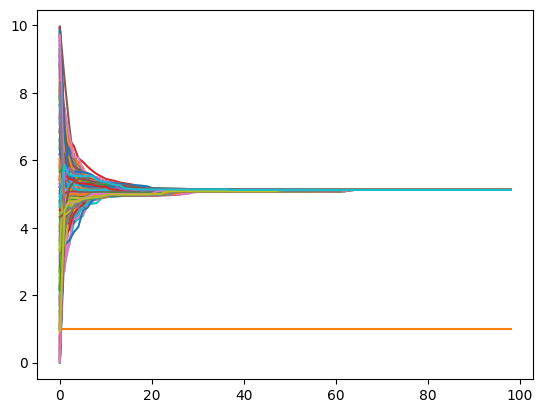

In [175]:
r=consensus(x0, adjacency_matrix, nit=100, attck_vals={1:lambda x:1})

plt.plot(list(range(len(r))),list(r))
plt.show()

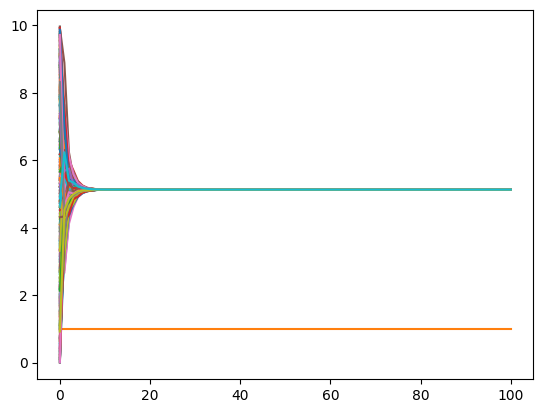

In [178]:
r=msr_consensus(x0, adjacency_matrix, max_iterations=100, attck_vals={1:lambda x:1},f=1)
plt.plot(list(range(len(r))),list(r))
plt.show()

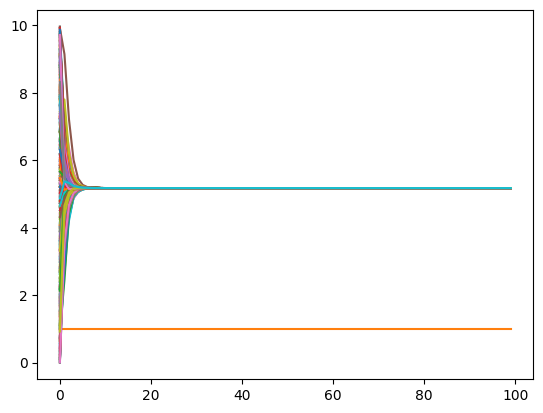

In [179]:
r=repBasedConsensus(x0, adjacency_matrix, max_iterations=100, attck_vals={1:lambda x:1},f=1)
plt.plot(list(range(len(r))),list(r))
plt.show()

In [206]:
%timeit consensus(x0, adjacency_matrix, nit=100, attck_vals={0:lambda x:1})

26.2 s ± 713 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [207]:
%timeit msr_consensus(x0, adjacency_matrix, max_iterations=100, attck_vals={0:lambda x:1},f=1)

1.1 s ± 8.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [208]:
%timeit repBasedConsensus(x0, adjacency_matrix, max_iterations=100, attck_vals={0:lambda x:1},f=1)

7.26 s ± 41.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Large-scale networks - 500 nodes

In [197]:
x0 = list(10*random() for i in range(500))
edges=[(1,10), (1,36), (1,59), (1,94), (1,176), (1,224), (1,272), (1,296), (1,369), (1,423), (1,469), (2,12), (2,30), (2,86), (2,131), (2,143), (2,155), (2,163), (2,172), (2,173), (2,183), (2,211), (2,248), (2,273), (2,303), (2,367), (2,387), (2,396), (2,423), (2,479), (2,493), (3,19), (3,27), (3,87), (3,105), (3,148), (3,176), (3,277), (3,289), (3,341), (3,343), (3,431), (3,451), (3,488), (3,492), (4,39), (4,90), (4,126), (4,156), (4,167), (4,248), (4,289), (4,291), (4,334), (4,399), (4,416), (4,419), (4,426), (5,207), (5,216), (5,217), (5,260), (5,290), (5,299), (5,316), (5,333), (5,363), (5,390), (6,18), (6,64), (6,85), (6,121), (6,174), (6,188), (6,238), (6,306), (6,392), (7,21), (7,28), (7,39), (7,75), (7,89), (7,156), (7,184), (7,189), (7,201), (7,221), (7,285), (7,327), (7,348), (7,358), (7,392), (7,415), (7,478), (8,13), (8,67), (8,240), (8,263), (8,349), (8,352), (8,402), (8,422), (8,470), (8,472), (8,474), (9,54), (9,145), (9,177), (9,201), (9,227), (9,246), (9,309), (9,372), (10,12), (10,47), (10,83), (10,99), (10,121), (10,153), (10,193), (10,228), (10,235), (10,433), (11,25), (11,75), (11,169), (11,174), (11,237), (11,325), (11,365), (11,386), (11,488), (11,498), (12,63), (12,80), (12,85), (12,141), (12,149), (12,242), (12,295), (12,304), (12,327), (12,347), (12,425), (13,27), (13,28), (13,38), (13,83), (13,149), (13,338), (13,342), (13,353), (13,363), (13,396), (13,399), (13,409), (13,458), (13,461), (13,467), (13,500), (14,24), (14,34), (14,55), (14,145), (14,176), (14,218), (14,241), (14,279), (14,280), (14,310), (14,340), (14,377), (14,424), (14,489), (15,63), (15,143), (15,151), (15,230), (15,249), (15,277), (15,286), (15,289), (15,403), (15,463), (15,466), (16,42), (16,46), (16,120), (16,147), (16,364), (16,387), (16,451), (16,453), (16,487), (17,49), (17,79), (17,182), (17,240), (17,330), (17,366), (18,33), (18,85), (18,112), (18,159), (18,161), (18,212), (18,218), (18,357), (18,363), (18,407), (19,120), (19,203), (19,213), (19,235), (19,241), (19,306), (19,309), (19,345), (19,350), (19,421), (19,422), (19,483), (20,40), (20,191), (20,287), (20,317), (20,348), (20,358), (20,361), (20,373), (20,401), (20,435), (20,436), (20,459), (21,238), (21,331), (21,393), (21,410), (22,45), (22,56), (22,190), (22,194), (22,242), (22,274), (23,135), (23,186), (23,243), (23,275), (23,306), (23,326), (23,360), (23,398), (23,412), (23,432), (23,434), (23,473), (23,483), (23,487), (23,497), (24,101), (24,131), (24,133), (24,145), (24,235), (24,252), (24,336), (24,360), (24,400), (24,489), (25,110), (25,119), (25,129), (25,134), (25,149), (25,214), (25,215), (25,218), (25,236), (25,242), (25,243), (25,272), (25,285), (25,356), (25,441), (25,458), (25,485), (26,123), (26,126), (26,138), (26,492), (27,29), (27,36), (27,53), (27,212), (27,274), (27,286), (27,312), (27,396), (27,398), (28,128), (28,135), (28,233), (28,235), (28,251), (28,270), (28,310), (28,404), (28,428), (28,453), (28,474), (29,99), (29,115), (29,156), (29,303), (29,343), (29,421), (29,473), (29,482), (29,486), (29,498), (29,499), (29,500), (30,58), (30,113), (30,122), (30,125), (30,155), (30,181), (30,240), (30,246), (30,259), (30,331), (30,343), (30,366), (30,370), (30,381), (31,58), (31,68), (31,88), (31,151), (31,178), (31,216), (31,221), (31,244), (31,286), (31,288), (31,328), (31,369), (31,379), (31,381), (31,387), (31,433), (31,471), (31,491), (31,499), (32,132), (32,139), (32,207), (32,221), (32,324), (32,339), (32,397), (32,413), (33,42), (33,124), (33,126), (33,137), (33,138), (33,142), (33,177), (33,227), (33,347), (33,430), (33,487), (34,51), (34,137), (34,318), (34,339), (34,388), (34,437), (34,471), (35,55), (35,75), (35,84), (35,168), (35,179), (35,197), (35,217), (35,228), (35,347), (35,348), (35,372), (35,406), (35,432), (36,59), (36,79), (36,94), (36,140), (36,156), (36,327), (36,366), (36,394), (36,427), (36,428), (36,488), (36,498), (37,40), (37,44), (37,186), (37,208), (37,220), (37,282), (37,291), (37,295), (37,316), (37,332), (37,343), (37,364), (37,409), (37,440), (37,475), (38,43), (38,91), (38,114), (38,141), (38,173), (38,348), (38,499), (39,60), (39,181), (39,338), (39,342), (39,355), (39,374), (39,380), (39,433), (40,55), (40,76), (40,178), (40,183), (40,227), (40,327), (40,372), (41,42), (41,56), (41,78), (41,120), (41,143), (41,146), (41,193), (41,196), (41,248), (41,363), (41,446), (41,469), (42,83), (42,91), (42,136), (42,155), (42,278), (42,298), (42,341), (42,479), (42,485), (43,44), (43,133), (43,152), (43,158), (43,210), (43,219), (43,245), (43,309), (43,388), (43,417), (43,457), (43,496), (44,165), (44,215), (44,373), (44,375), (44,409), (44,458), (44,473), (44,482), (44,491), (44,494), (45,74), (45,172), (45,207), (45,230), (45,285), (45,324), (45,326), (45,348), (45,369), (45,468), (46,91), (46,122), (46,150), (46,217), (46,226), (46,229), (46,239), (46,256), (46,298), (46,433), (46,471), (47,68), (47,73), (47,142), (47,147), (47,155), (47,176), (47,199), (47,233), (47,283), (47,315), (47,319), (47,413), (48,87), (48,143), (48,149), (48,169), (48,263), (48,277), (48,406), (48,456), (49,126), (49,156), (49,176), (49,188), (49,228), (49,248), (49,257), (49,281), (49,345), (49,389), (49,404), (49,415), (49,424), (49,459), (49,485), (50,155), (50,268), (50,337), (50,382), (50,384), (50,426), (50,436), (50,440), (50,490), (51,63), (51,224), (51,263), (51,286), (51,372), (51,381), (51,396), (51,398), (52,119), (52,139), (52,189), (52,191), (52,232), (52,283), (52,313), (52,326), (52,333), (52,364), (52,485), (52,493), (53,57), (53,61), (53,69), (53,73), (53,298), (53,340), (53,402), (53,409), (53,429), (53,436), (53,445), (53,451), (54,250), (54,303), (54,382), (54,424), (55,80), (55,120), (55,200), (55,220), (55,300), (55,323), (55,373), (55,399), (55,486), (55,489), (55,494), (56,90), (56,98), (56,211), (56,227), (56,269), (56,292), (56,367), (56,426), (56,428), (56,468), (57,128), (57,152), (57,197), (57,275), (57,278), (57,359), (57,414), (57,438), (57,449), (57,497), (58,61), (58,95), (58,111), (58,113), (58,166), (58,193), (58,273), (58,372), (58,396), (58,433), (58,446), (58,452), (58,485), (58,499), (59,76), (59,125), (59,136), (59,214), (59,235), (59,239), (59,263), (59,313), (59,329), (59,408), (59,427), (59,436), (59,441), (59,459), (59,465), (59,466), (59,467), (60,69), (60,85), (60,119), (60,132), (60,235), (60,281), (60,332), (60,355), (60,365), (60,381), (60,486), (61,104), (61,130), (61,136), (61,200), (61,212), (61,326), (61,352), (61,483), (61,489), (61,496), (62,101), (62,200), (62,201), (62,227), (62,236), (62,240), (62,255), (62,286), (62,296), (62,311), (62,463), (62,490), (63,79), (63,130), (63,248), (63,255), (63,313), (63,375), (63,479), (63,489), (64,94), (64,113), (64,129), (64,148), (64,369), (64,410), (64,423), (64,434), (64,465), (64,479), (64,493), (65,71), (65,103), (65,143), (65,163), (65,199), (65,221), (65,336), (65,351), (65,374), (65,433), (65,435), (65,470), (65,482), (66,103), (66,118), (66,201), (66,255), (66,384), (66,481), (67,110), (67,144), (67,277), (67,278), (67,289), (67,293), (67,300), (67,312), (67,362), (67,481), (67,487), (68,74), (68,135), (68,218), (68,305), (68,334), (68,363), (68,365), (68,410), (68,447), (68,455), (68,459), (69,116), (69,165), (69,168), (69,211), (69,245), (69,306), (69,354), (69,369), (69,390), (69,394), (69,423), (69,436), (69,437), (69,440), (69,447), (69,472), (69,484), (70,104), (70,114), (70,124), (70,173), (70,240), (70,294), (70,332), (70,343), (70,373), (70,377), (70,401), (70,431), (70,443), (70,478), (70,491), (71,163), (71,215), (71,306), (71,307), (71,367), (71,387), (71,394), (71,425), (71,491), (71,492), (71,498), (71,499), (72,121), (72,135), (72,189), (72,227), (72,285), (72,328), (72,336), (72,369), (72,403), (72,458), (72,460), (72,475), (72,492), (73,89), (73,123), (73,144), (73,178), (73,213), (73,254), (73,267), (73,311), (73,333), (73,382), (73,463), (74,171), (74,199), (74,205), (74,275), (74,349), (74,383), (74,408), (74,434), (74,453), (74,470), (75,87), (75,171), (75,177), (75,189), (75,201), (75,225), (75,226), (75,271), (75,320), (75,321), (75,407), (75,478), (75,497), (76,87), (76,258), (76,283), (76,363), (76,371), (76,430), (76,433), (76,444), (77,154), (77,225), (77,274), (77,411), (78,93), (78,115), (78,213), (78,222), (78,229), (78,259), (78,273), (78,312), (78,354), (78,367), (78,387), (78,409), (78,498), (79,104), (79,121), (79,147), (79,158), (79,330), (79,349), (80,88), (80,95), (80,98), (80,126), (80,160), (80,189), (80,206), (80,274), (80,353), (80,369), (80,459), (80,461), (80,467), (81,120), (81,151), (81,191), (81,420), (81,451), (81,494), (82,106), (82,157), (82,203), (82,244), (82,257), (82,267), (82,313), (82,320), (82,357), (82,388), (82,453), (82,459), (82,468), (82,476), (83,123), (83,291), (83,302), (83,320), (83,328), (83,449), (83,472), (84,121), (84,155), (84,194), (84,225), (84,274), (84,401), (84,413), (84,427), (84,429), (84,479), (84,496), (85,89), (85,101), (85,174), (85,206), (85,226), (85,256), (85,273), (85,418), (85,467), (86,102), (86,326), (86,345), (86,346), (87,118), (87,123), (87,162), (87,212), (87,219), (87,228), (87,253), (87,313), (87,450), (87,460), (88,154), (88,173), (88,212), (88,216), (88,251), (88,304), (88,334), (88,368), (88,415), (88,421), (89,106), (89,144), (89,164), (89,233), (89,248), (89,267), (89,286), (89,291), (89,316), (89,342), (89,365), (89,481), (90,157), (90,163), (90,202), (90,225), (90,241), (90,262), (90,374), (90,497), (91,100), (91,137), (91,151), (91,156), (91,173), (91,236), (91,238), (91,468), (91,474), (92,102), (92,103), (92,126), (92,152), (92,161), (92,166), (92,173), (92,194), (92,199), (92,221), (92,234), (92,258), (92,291), (92,309), (92,337), (92,338), (92,352), (92,408), (92,495), (92,496), (93,94), (93,123), (93,195), (93,239), (93,268), (93,343), (93,417), (94,164), (94,236), (94,250), (94,290), (94,311), (94,320), (94,476), (95,187), (95,194), (95,211), (95,231), (95,256), (95,314), (95,363), (95,375), (95,427), (95,445), (95,450), (95,458), (95,475), (95,497), (96,145), (96,148), (96,265), (96,375), (96,453), (96,487), (97,152), (97,200), (97,257), (97,276), (97,296), (97,334), (97,367), (97,484), (98,107), (98,179), (98,184), (98,294), (98,303), (98,359), (98,376), (98,409), (98,469), (98,490), (98,491), (99,110), (99,271), (99,285), (99,296), (99,309), (99,392), (99,441), (99,487), (100,227), (100,320), (100,372), (100,436), (100,451), (101,123), (101,262), (101,329), (101,331), (101,429), (101,471), (102,112), (102,139), (102,171), (102,172), (102,189), (102,241), (102,435), (102,467), (103,165), (103,202), (103,207), (103,215), (103,259), (103,336), (103,362), (103,421), (103,473), (103,479), (104,120), (104,165), (104,255), (104,349), (104,388), (104,425), (104,433), (104,454), (104,493), (105,108), (105,129), (105,137), (105,183), (105,244), (105,251), (105,310), (105,332), (105,409), (105,422), (106,108), (106,155), (106,174), (106,209), (106,302), (106,351), (106,385), (106,468), (106,480), (107,149), (107,161), (107,190), (107,222), (107,226), (107,278), (107,289), (107,313), (107,401), (107,405), (107,433), (107,488), (107,494), (108,114), (108,161), (108,204), (108,252), (108,260), (108,266), (108,357), (108,395), (108,446), (108,460), (108,474), (109,171), (109,172), (109,187), (109,231), (109,267), (109,333), (109,348), (109,404), (110,129), (110,190), (110,211), (110,244), (110,340), (110,366), (110,407), (110,419), (110,483), (110,485), (111,120), (111,145), (111,163), (111,181), (111,194), (111,202), (111,294), (111,308), (111,368), (111,424), (111,457), (111,492), (112,116), (112,126), (112,161), (112,173), (112,241), (112,281), (112,308), (112,343), (112,361), (112,383), (113,114), (113,209), (113,216), (113,328), (113,379), (113,389), (113,395), (113,400), (113,455), (113,469), (114,132), (114,207), (114,247), (114,258), (114,349), (114,398), (114,400), (114,467), (114,483), (114,487), (114,496), (115,138), (115,142), (115,193), (115,231), (115,342), (115,346), (115,359), (115,423), (115,472), (116,327), (116,377), (116,386), (116,423), (116,489), (117,154), (117,172), (117,181), (117,192), (117,235), (117,261), (117,281), (117,299), (117,315), (117,321), (117,346), (117,365), (117,454), (118,156), (118,168), (118,187), (118,214), (118,253), (118,369), (118,405), (118,425), (119,131), (119,194), (119,229), (119,233), (119,259), (119,289), (119,327), (119,343), (119,345), (119,361), (119,375), (119,385), (119,412), (120,131), (120,275), (120,336), (120,346), (120,354), (120,368), (120,418), (120,485), (121,262), (121,295), (121,336), (121,358), (121,363), (121,432), (121,439), (121,475), (121,489), (122,125), (122,146), (122,153), (122,209), (122,253), (122,269), (122,326), (122,329), (122,387), (122,488), (123,156), (123,265), (123,349), (123,367), (123,416), (123,433), (124,158), (124,322), (124,368), (125,179), (125,195), (125,219), (125,233), (125,311), (125,316), (125,375), (125,387), (125,394), (125,433), (125,455), (125,460), (126,134), (126,144), (126,197), (126,216), (126,263), (126,282), (126,289), (126,316), (126,343), (126,364), (126,416), (126,432), (127,180), (127,193), (127,321), (127,358), (127,402), (127,416), (127,479), (127,483), (128,165), (128,330), (128,409), (128,451), (129,149), (129,151), (129,170), (129,183), (129,218), (129,242), (129,250), (129,273), (129,286), (129,403), (129,415), (130,177), (130,188), (130,238), (130,261), (130,274), (130,289), (130,292), (130,293), (130,302), (130,347), (130,414), (131,138), (131,201), (131,243), (131,371), (131,376), (131,487), (132,142), (132,149), (132,236), (132,257), (132,382), (132,406), (132,437), (132,456), (132,457), (132,476), (132,482), (133,145), (133,193), (133,230), (133,239), (133,242), (133,279), (133,286), (133,299), (133,360), (133,362), (133,364), (133,443), (134,163), (134,235), (134,246), (134,250), (134,266), (134,283), (134,299), (134,383), (134,427), (135,136), (135,181), (135,228), (135,243), (135,260), (135,280), (135,292), (135,295), (135,316), (135,378), (135,444), (135,462), (135,467), (135,497), (136,144), (136,145), (136,149), (136,155), (136,216), (136,232), (136,234), (136,263), (136,267), (136,302), (136,340), (136,373), (136,420), (136,442), (137,144), (137,272), (137,366), (137,461), (137,498), (138,156), (138,164), (138,193), (138,313), (138,325), (138,383), (138,443), (138,480), (139,221), (139,236), (139,244), (139,313), (139,315), (139,395), (139,485), (140,153), (140,247), (140,395), (140,433), (140,455), (141,161), (141,162), (141,258), (141,283), (141,306), (141,321), (141,454), (141,487), (141,498), (142,266), (142,304), (142,495), (143,199), (143,200), (143,244), (143,257), (143,359), (143,365), (143,386), (143,391), (143,397), (143,492), (143,497), (144,178), (144,190), (144,204), (144,214), (144,236), (144,271), (144,295), (144,312), (144,321), (144,346), (144,372), (144,377), (144,396), (144,417), (144,482), (145,192), (145,194), (145,235), (145,252), (145,288), (145,306), (145,361), (145,365), (145,394), (145,398), (145,452), (145,455), (146,201), (146,263), (146,273), (146,298), (146,338), (146,388), (147,184), (147,196), (147,304), (147,322), (147,336), (147,348), (147,358), (147,407), (147,433), (147,456), (147,485), (148,206), (148,227), (148,234), (148,265), (148,267), (148,294), (148,309), (148,377), (148,423), (148,429), (148,445), (148,454), (148,489), (149,211), (149,227), (149,238), (149,247), (149,295), (149,436), (149,467), (149,486), (150,160), (150,188), (150,234), (150,360), (150,371), (150,425), (150,456), (150,489), (151,176), (151,179), (151,384), (151,408), (151,411), (151,415), (152,211), (152,260), (152,338), (152,351), (152,453), (152,461), (153,200), (153,217), (153,261), (153,275), (153,276), (153,302), (153,379), (153,490), (154,192), (154,239), (154,275), (154,281), (154,317), (154,332), (154,409), (155,183), (155,207), (155,249), (155,389), (155,406), (156,307), (156,411), (156,494), (157,199), (157,216), (157,297), (157,389), (157,394), (157,416), (157,420), (157,481), (158,161), (158,166), (158,211), (158,213), (158,434), (158,481), (159,274), (159,284), (159,303), (159,394), (159,411), (159,420), (159,478), (159,484), (160,220), (160,232), (160,252), (160,321), (160,335), (160,340), (160,363), (160,378), (160,380), (160,424), (160,457), (161,243), (161,256), (161,294), (161,318), (161,336), (161,385), (161,421), (161,430), (161,439), (161,464), (161,497), (162,192), (162,248), (162,292), (162,298), (162,310), (162,343), (162,347), (162,385), (162,392), (162,418), (162,436), (162,460), (163,167), (163,175), (163,218), (163,221), (163,228), (163,264), (163,293), (163,294), (163,297), (163,412), (163,471), (164,177), (164,208), (164,284), (164,302), (164,324), (164,341), (164,365), (164,381), (164,403), (164,463), (164,465), (164,486), (165,190), (165,244), (165,253), (165,285), (165,291), (165,317), (165,403), (165,425), (165,440), (165,442), (165,451), (166,189), (166,207), (166,285), (166,318), (166,343), (166,364), (166,385), (166,409), (166,429), (166,457), (167,218), (167,227), (167,283), (167,319), (167,323), (167,326), (167,330), (167,394), (167,424), (167,458), (168,181), (168,215), (168,285), (168,292), (168,317), (168,346), (168,373), (168,398), (168,403), (169,263), (169,314), (169,346), (169,378), (169,408), (170,195), (170,196), (170,217), (170,227), (170,231), (170,264), (170,322), (170,359), (170,362), (171,190), (171,192), (171,443), (171,446), (171,472), (172,179), (172,196), (172,258), (172,386), (172,407), (172,428), (172,472), (172,494), (173,242), (173,246), (173,264), (173,280), (173,292), (173,295), (174,212), (174,223), (174,257), (174,291), (174,332), (174,344), (174,381), (174,424), (174,499), (175,201), (175,221), (175,245), (175,267), (175,283), (175,307), (175,329), (175,414), (176,183), (176,223), (176,263), (176,279), (176,306), (176,311), (176,324), (176,355), (176,411), (176,431), (176,439), (177,207), (177,400), (178,228), (178,274), (178,306), (178,309), (178,350), (178,389), (178,400), (178,450), (178,472), (179,231), (179,266), (179,280), (179,308), (179,325), (179,344), (179,352), (179,408), (179,410), (179,420), (179,429), (179,432), (179,461), (180,217), (180,257), (180,258), (180,349), (180,437), (180,445), (180,459), (181,262), (181,354), (181,379), (181,398), (181,399), (182,191), (182,192), (182,227), (182,241), (182,258), (182,299), (182,382), (182,416), (182,462), (182,467), (182,484), (183,325), (183,329), (183,335), (183,463), (183,473), (184,205), (184,208), (184,301), (184,302), (184,391), (184,446), (184,472), (185,213), (185,282), (185,286), (185,379), (185,453), (185,462), (185,476), (186,195), (186,230), (186,238), (186,260), (186,349), (186,416), (186,430), (186,453), (186,478), (186,484), (187,199), (187,237), (187,259), (187,318), (187,330), (187,380), (187,390), (187,442), (187,445), (187,467), (187,491), (187,494), (188,211), (188,264), (188,266), (188,268), (188,295), (188,318), (188,344), (188,379), (188,387), (188,392), (188,486), (189,208), (189,229), (189,241), (189,262), (189,275), (189,302), (189,347), (189,354), (189,383), (189,395), (189,413), (189,445), (189,458), (190,207), (190,234), (190,245), (190,274), (190,275), (190,338), (190,361), (190,383), (190,470), (190,494), (191,238), (191,266), (191,300), (191,301), (191,484), (192,220), (192,256), (192,328), (192,435), (192,445), (192,491), (193,349), (193,402), (193,462), (193,471), (194,208), (194,222), (194,272), (194,291), (194,352), (194,455), (194,494), (195,214), (195,350), (195,354), (195,355), (195,368), (195,470), (195,480), (196,374), (196,455), (196,477), (197,209), (197,225), (197,334), (197,402), (197,452), (197,453), (198,312), (198,355), (198,434), (198,445), (198,475), (199,242), (199,248), (199,307), (199,345), (199,418), (199,427), (199,461), (199,471), (199,473), (200,354), (200,481), (200,500), (201,230), (201,296), (201,407), (201,493), (202,214), (202,226), (202,271), (202,332), (202,391), (202,453), (202,458), (203,207), (203,252), (203,304), (203,323), (203,345), (203,365), (203,411), (203,440), (203,492), (204,228), (204,316), (204,420), (204,427), (204,441), (204,453), (204,456), (204,461), (204,475), (205,225), (205,336), (205,343), (205,381), (205,409), (205,439), (205,471), (206,233), (206,247), (206,253), (206,347), (206,350), (206,357), (206,375), (206,397), (206,408), (206,409), (206,489), (207,230), (207,248), (207,294), (207,296), (207,306), (207,426), (207,455), (207,482), (207,484), (208,231), (208,242), (208,250), (208,287), (208,294), (208,297), (208,409), (208,482), (209,215), (209,272), (209,326), (209,334), (209,407), (209,439), (210,216), (210,322), (210,365), (210,399), (210,499), (211,221), (211,245), (211,275), (211,281), (211,308), (211,309), (211,379), (211,381), (211,390), (211,396), (211,460), (212,304), (212,328), (212,366), (212,382), (212,387), (212,399), (212,415), (212,499), (213,259), (213,271), (213,277), (213,303), (213,376), (213,455), (214,248), (214,331), (214,344), (214,411), (214,423), (214,433), (214,448), (214,471), (214,482), (215,267), (215,307), (215,477), (216,278), (216,286), (216,348), (217,251), (217,258), (217,273), (217,317), (217,337), (217,368), (217,384), (217,399), (217,430), (217,459), (217,470), (218,295), (218,306), (218,368), (218,395), (218,417), (218,460), (218,465), (218,479), (219,238), (219,277), (219,285), (219,336), (219,489), (219,492), (220,288), (220,298), (220,377), (220,439), (220,465), (220,466), (220,478), (221,236), (221,248), (221,281), (221,355), (221,396), (221,435), (221,483), (222,241), (222,267), (222,277), (222,355), (222,365), (222,389), (222,486), (223,226), (223,269), (223,303), (223,324), (223,390), (223,408), (223,417), (223,434), (223,438), (223,472), (224,267), (224,284), (224,291), (224,318), (224,326), (224,370), (224,442), (224,447), (224,494), (225,254), (225,281), (225,328), (225,369), (225,466), (225,476), (226,260), (226,335), (226,452), (226,471), (227,278), (227,295), (227,308), (227,328), (227,330), (227,336), (227,417), (228,267), (228,277), (228,297), (228,359), (228,410), (228,422), (228,441), (228,470), (228,474), (228,486), (229,289), (229,314), (229,324), (229,364), (229,490), (229,499), (230,309), (230,323), (230,377), (230,499), (231,253), (231,310), (231,346), (231,348), (231,372), (231,378), (231,411), (231,450), (231,466), (231,488), (231,493), (232,263), (232,331), (232,392), (232,395), (232,408), (232,424), (232,460), (233,297), (233,338), (233,359), (233,406), (233,427), (233,433), (233,435), (233,454), (233,467), (233,475), (233,493), (234,259), (234,348), (234,389), (235,238), (235,274), (235,306), (235,310), (235,325), (235,356), (235,363), (235,488), (235,493), (235,499), (236,256), (236,313), (236,382), (237,239), (237,260), (237,287), (237,300), (237,307), (237,308), (237,346), (237,422), (237,463), (238,243), (238,250), (238,344), (238,349), (238,350), (238,388), (238,444), (238,457), (238,463), (238,482), (238,494), (239,335), (239,401), (240,271), (240,275), (240,298), (240,315), (240,317), (240,320), (240,366), (240,449), (241,261), (241,269), (241,375), (241,473), (242,351), (242,377), (242,430), (243,249), (243,307), (243,324), (243,426), (243,464), (244,354), (244,393), (244,396), (244,409), (244,417), (244,423), (244,450), (244,454), (245,257), (245,264), (245,441), (245,494), (246,252), (246,280), (246,309), (246,367), (246,397), (246,405), (246,468), (247,290), (247,351), (247,440), (247,441), (248,286), (248,301), (248,344), (248,364), (248,385), (248,407), (248,427), (248,430), (248,460), (248,462), (249,278), (249,396), (249,444), (249,485), (250,317), (250,407), (250,471), (251,252), (251,255), (251,285), (251,338), (251,349), (251,358), (251,387), (251,418), (251,439), (252,273), (252,279), (252,298), (252,305), (252,342), (252,373), (253,284), (253,332), (253,390), (253,458), (253,480), (254,269), (254,271), (254,281), (254,299), (254,315), (254,410), (254,427), (255,256), (255,301), (255,304), (255,331), (255,413), (255,465), (256,259), (256,261), (256,275), (256,278), (256,283), (256,295), (256,300), (256,303), (256,318), (256,368), (256,441), (256,459), (256,484), (256,485), (257,318), (257,467), (257,468), (257,474), (257,493), (257,497), (258,264), (258,284), (258,294), (258,398), (259,295), (259,305), (259,416), (259,432), (260,261), (260,282), (260,302), (260,358), (260,386), (260,409), (260,412), (260,448), (261,371), (261,372), (262,296), (262,304), (262,379), (262,430), (262,497), (263,340), (263,430), (263,490), (263,498), (264,290), (264,393), (264,421), (264,437), (264,440), (264,443), (265,296), (265,349), (265,358), (265,382), (265,439), (265,465), (265,473), (266,298), (266,300), (266,312), (266,343), (266,407), (266,453), (267,271), (267,286), (267,327), (267,371), (268,312), (268,375), (268,396), (268,454), (268,457), (268,485), (269,305), (269,326), (269,330), (269,458), (270,322), (270,348), (270,357), (270,408), (270,429), (270,444), (270,451), (271,314), (271,321), (271,325), (271,335), (271,348), (271,353), (271,354), (271,386), (271,434), (271,467), (271,489), (272,387), (272,412), (272,422), (272,441), (273,313), (273,440), (273,463), (274,279), (274,298), (274,315), (274,361), (274,375), (274,409), (275,277), (275,308), (275,316), (275,328), (275,382), (275,450), (276,339), (276,392), (276,407), (276,410), (276,436), (276,481), (277,308), (277,325), (277,377), (277,433), (277,442), (277,447), (277,485), (278,287), (278,361), (278,381), (278,395), (278,423), (278,449), (279,295), (279,350), (279,436), (279,480), (280,300), (280,315), (280,336), (280,448), (280,462), (280,463), (280,484), (280,493), (280,498), (281,291), (281,297), (281,362), (281,387), (281,465), (282,347), (282,401), (283,288), (283,335), (283,400), (283,403), (283,466), (283,468), (284,299), (284,314), (284,414), (284,418), (285,311), (285,337), (285,359), (285,385), (285,427), (285,443), (285,446), (285,447), (285,455), (286,295), (286,333), (286,423), (286,464), (286,493), (287,317), (287,469), (288,345), (288,368), (288,402), (288,418), (288,430), (288,483), (289,306), (289,327), (289,388), (289,400), (290,306), (290,328), (290,395), (290,435), (290,444), (290,448), (291,300), (291,353), (291,384), (291,396), (291,398), (291,424), (292,358), (292,419), (292,425), (292,476), (292,496), (292,499), (293,337), (293,444), (293,477), (294,346), (294,372), (294,413), (294,484), (295,296), (295,324), (295,350), (295,404), (295,408), (295,444), (295,495), (295,500), (296,321), (296,327), (296,396), (296,404), (296,406), (296,433), (296,459), (296,475), (297,431), (297,452), (297,456), (298,327), (298,483), (299,308), (299,350), (299,385), (299,397), (299,405), (299,427), (299,494), (300,362), (300,383), (300,484), (300,485), (300,499), (301,307), (301,312), (301,351), (301,364), (301,392), (301,427), (301,447), (301,449), (302,348), (302,387), (302,397), (302,444), (302,494), (303,356), (303,388), (303,394), (303,419), (304,365), (304,436), (305,387), (305,393), (305,410), (305,414), (305,422), (305,455), (305,463), (305,476), (305,485), (305,492), (306,346), (307,322), (307,338), (307,367), (307,397), (307,425), (307,451), (307,472), (308,337), (308,343), (308,387), (308,407), (308,418), (308,442), (309,365), (309,375), (309,428), (309,452), (309,456), (310,411), (310,442), (311,359), (311,379), (311,387), (311,454), (311,499), (312,364), (312,425), (312,456), (312,465), (312,494), (313,323), (313,325), (313,337), (313,370), (313,451), (313,452), (313,482), (314,320), (314,373), (314,381), (314,397), (314,469), (314,495), (315,344), (315,378), (315,382), (315,385), (315,492), (316,320), (316,368), (316,497), (316,499), (317,354), (317,393), (317,396), (317,474), (318,419), (318,494), (319,329), (319,392), (319,413), (319,426), (319,485), (320,345), (321,356), (321,357), (321,392), (321,407), (322,327), (322,364), (323,327), (323,377), (323,392), (323,396), (323,404), (323,472), (324,348), (324,351), (324,406), (324,422), (325,367), (325,377), (325,400), (325,469), (326,390), (326,475), (327,344), (327,364), (327,425), (327,429), (327,440), (327,455), (327,463), (327,483), (327,489), (328,361), (328,390), (328,497), (329,352), (329,357), (329,370), (329,373), (329,392), (329,422), (329,465), (329,481), (330,385), (330,453), (330,465), (330,499), (331,356), (331,382), (331,388), (331,482), (331,488), (332,405), (332,413), (332,418), (332,448), (333,476), (334,475), (335,353), (335,425), (335,472), (335,481), (335,500), (336,439), (336,493), (337,338), (337,459), (337,460), (337,468), (338,366), (338,393), (338,443), (338,487), (339,383), (339,451), (339,470), (339,495), (340,343), (340,408), (340,440), (341,429), (341,451), (342,345), (342,355), (342,389), (342,412), (342,422), (343,434), (343,447), (343,468), (344,460), (344,489), (345,349), (345,434), (345,472), (345,494), (345,497), (346,373), (346,482), (346,495), (347,424), (347,442), (347,455), (348,360), (348,428), (349,414), (350,367), (350,460), (350,462), (350,467), (350,484), (351,370), (351,374), (351,419), (352,369), (352,426), (352,452), (353,449), (353,451), (353,452), (353,478), (354,398), (354,408), (354,410), (354,434), (354,444), (354,473), (355,366), (355,415), (355,425), (355,426), (356,391), (356,397), (356,412), (357,375), (357,451), (357,490), (357,492), (358,389), (358,448), (360,370), (360,378), (361,407), (361,416), (361,432), (361,436), (362,476), (363,377), (363,412), (363,474), (365,424), (365,464), (365,478), (366,400), (366,459), (366,484), (367,368), (367,420), (367,447), (368,388), (368,394), (369,388), (369,403), (369,450), (369,479), (369,499), (370,384), (371,394), (371,449), (372,460), (372,500), (373,374), (373,432), (373,500), (374,376), (374,422), (375,378), (375,446), (375,492), (376,442), (377,390), (377,453), (378,423), (378,464), (378,471), (379,384), (379,425), (379,484), (380,417), (380,437), (380,438), (380,493), (381,453), (382,433), (383,385), (383,390), (383,443), (383,460), (384,406), (384,430), (384,463), (384,490), (385,405), (385,445), (385,446), (385,488), (386,405), (386,407), (386,409), (386,447), (387,453), (387,471), (387,492), (388,410), (388,415), (388,422), (388,492), (390,415), (390,451), (390,480), (390,490), (391,446), (391,453), (392,461), (394,472), (395,397), (395,430), (395,485), (396,497), (396,499), (397,412), (397,413), (398,407), (398,411), (398,484), (398,497), (399,421), (399,429), (399,437), (399,446), (399,456), (399,464), (399,466), (399,475), (402,463), (402,489), (403,499), (404,425), (404,440), (404,464), (405,448), (407,415), (408,442), (408,494), (409,427), (409,449), (410,445), (410,483), (411,426), (411,491), (412,422), (412,441), (413,455), (413,462), (413,464), (413,475), (414,417), (414,423), (414,433), (414,452), (415,428), (415,486), (415,493), (416,424), (416,457), (416,485), (416,493), (417,437), (418,446), (419,456), (419,472), (419,482), (420,463), (420,473), (420,496), (421,455), (422,463), (422,493), (422,497), (423,428), (423,467), (423,470), (423,488), (425,500), (426,479), (426,481), (427,430), (428,452), (428,471), (429,438), (429,443), (429,484), (430,436), (430,439), (430,447), (430,458), (431,486), (431,496), (432,473), (434,438), (434,464), (434,468), (434,484), (435,450), (435,459), (436,449), (436,482), (437,480), (438,444), (438,478), (440,466), (442,451), (442,459), (442,466), (442,476), (442,477), (443,495), (444,483), (446,479), (448,459), (448,476), (449,462), (449,498), (450,453), (450,497), (451,484), (451,495), (452,475), (453,482), (453,490), (456,491), (459,461), (460,483), (460,485), (466,480), (466,493), (467,496), (469,475), (469,484), (473,489), (475,477), (479,498), (480,494), (481,493), (483,496), (485,491), (486,489), (487,497), (488,489)]
adjacency_matrix = [[0 for i in range(500)] for j in range(500)]
for x,y in edges:
    adjacency_matrix[x-1][y-1] = 1
    adjacency_matrix[y-1][x-1] = 1

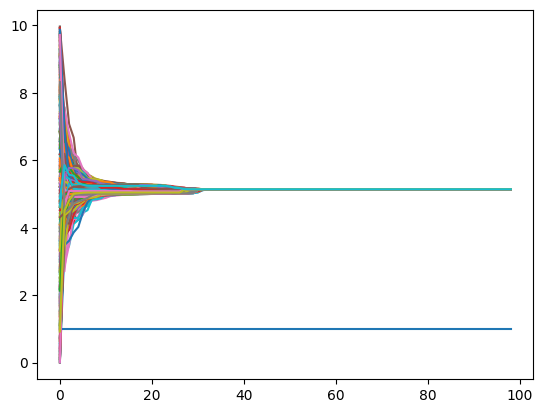

In [174]:
r=consensus(x0, adjacency_matrix, nit=100, attck_vals={1:lambda x:1})

plt.plot(list(range(len(r))),list(r))
plt.show()

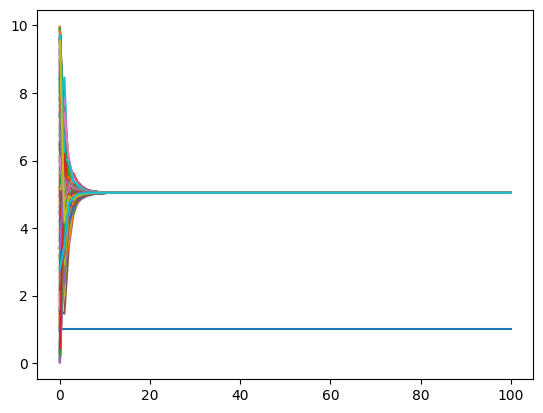

In [161]:
r=msr_consensus(x0, adjacency_matrix, max_iterations=100, attck_vals={1:lambda x:1}, f=1)
plt.plot(list(range(len(r))),list(r))
plt.show()

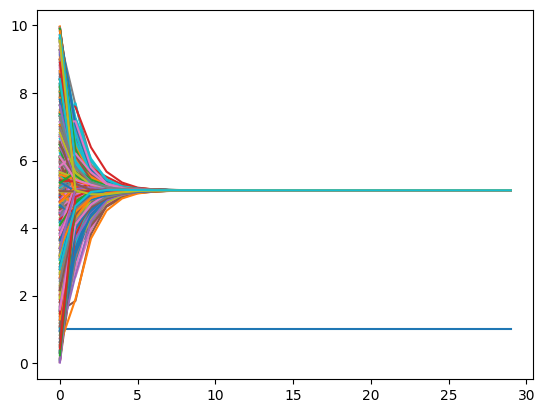

In [162]:
r=repBasedConsensus(x0, adjacency_matrix, max_iterations=30, attck_vals={1:lambda x:1}, f=1)
plt.plot(list(range(len(r))),list(r))
plt.show()

In [198]:
%timeit consensus(x0, adjacency_matrix, nit=100, attck_vals={1:lambda x:1})

12.5 s ± 429 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [199]:
%timeit msr_consensus(x0, adjacency_matrix, max_iterations=100, attck_vals={0:lambda x:1})

493 ms ± 1.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [200]:
%timeit repBasedConsensus(x0, adjacency_matrix, max_iterations=100, attck_vals={0:lambda x:1})

2.27 s ± 200 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [201]:
edges=[(1,7), (1,8), (1,28), (1,34), (1,41), (1,52), (1,54), (1,59), (1,65), (1,75), (1,85), (2,12), (2,14), (2,29), (2,35), (2,36), (2,49), (2,60), (2,77), (2,79), (3,7), (3,8), (3,23), (3,29), (3,35), (3,45), (3,71), (3,76), (3,77), (3,78), (3,87), (3,89), (3,94), (4,32), (4,37), (4,50), (4,60), (4,63), (4,68), (4,69), (4,71), (4,74), (4,76), (5,14), (5,18), (5,21), (5,25), (5,30), (5,31), (5,69), (5,74), (5,81), (5,84), (5,92), (5,93), (5,100), (6,8), (6,15), (6,21), (6,24), (6,34), (6,43), (6,46), (6,73), (6,85), (7,14), (7,17), (7,29), (7,30), (7,32), (7,65), (7,67), (7,68), (7,72), (7,82), (7,84), (7,100), (8,21), (8,52), (8,69), (8,72), (8,81), (8,83), (9,13), (9,15), (9,21), (9,25), (9,28), (9,32), (9,34), (9,36), (9,52), (9,59), (9,72), (9,74), (10,11), (10,13), (10,16), (10,22), (10,29), (10,31), (10,42), (10,57), (10,59), (10,83), (10,85), (10,90), (10,92), (10,99), (11,19), (11,22), (11,26), (11,38), (11,47), (11,53), (11,62), (11,65), (11,73), (11,84), (11,85), (11,94), (12,26), (12,28), (12,45), (12,46), (12,47), (12,54), (12,77), (12,93), (13,17), (13,23), (13,25), (13,34), (13,35), (13,39), (13,40), (13,44), (13,53), (13,62), (13,74), (13,76), (13,77), (13,86), (13,90), (13,93), (14,27), (14,28), (14,29), (14,33), (14,36), (14,47), (14,51), (14,56), (14,62), (15,23), (15,41), (15,47), (15,50), (15,51), (15,56), (15,60), (15,71), (15,74), (15,79), (15,82), (15,95), (16,39), (16,49), (16,55), (16,58), (16,79), (16,83), (16,90), (16,96), (17,18), (17,28), (17,33), (17,38), (17,46), (17,51), (17,55), (17,59), (17,61), (17,67), (17,73), (17,98), (18,22), (18,24), (18,26), (18,29), (18,31), (18,32), (18,39), (18,43), (18,51), (18,58), (18,63), (18,81), (18,90), (18,95), (18,100), (19,24), (19,36), (19,40), (19,45), (19,51), (19,56), (19,66), (19,82), (19,84), (19,86), (19,87), (19,91), (19,97), (19,98), (20,34), (20,44), (20,50), (20,51), (20,78), (20,81), (21,35), (21,37), (21,41), (21,49), (21,51), (21,58), (21,62), (21,65), (21,66), (21,69), (21,84), (21,87), (21,88), (21,100), (22,49), (22,52), (22,99), (23,25), (23,52), (23,63), (23,66), (23,69), (23,89), (23,90), (23,93), (24,28), (24,31), (24,32), (24,44), (24,48), (24,56), (24,59), (24,63), (24,75), (24,77), (25,27), (25,29), (25,34), (25,44), (25,59), (25,63), (25,69), (26,30), (26,36), (26,45), (26,52), (26,57), (26,72), (26,77), (26,79), (26,82), (26,97), (27,33), (27,41), (27,64), (27,67), (27,68), (27,76), (27,85), (27,96), (28,29), (28,46), (28,53), (28,60), (28,62), (28,64), (28,66), (28,67), (28,69), (28,86), (28,92), (29,33), (29,40), (29,44), (29,46), (29,60), (29,62), (29,79), (29,85), (30,32), (30,38), (30,43), (30,52), (30,54), (30,66), (30,70), (30,76), (30,77), (30,90), (30,93), (31,45), (31,47), (31,50), (31,51), (31,64), (31,69), (31,87), (31,99), (32,40), (32,45), (32,56), (32,87), (32,97), (33,50), (33,52), (33,67), (33,89), (33,90), (33,92), (34,36), (34,50), (34,61), (34,74), (34,82), (34,86), (34,96), (35,37), (35,44), (35,52), (35,56), (35,68), (35,69), (35,72), (35,73), (35,85), (35,87), (35,91), (36,43), (36,45), (36,46), (36,58), (36,63), (36,66), (36,67), (36,79), (36,87), (37,44), (37,48), (37,53), (37,62), (37,67), (37,68), (37,75), (37,77), (37,78), (37,79), (37,84), (37,86), (37,95), (38,51), (38,61), (38,65), (38,70), (38,75), (38,78), (38,81), (38,84), (38,94), (39,51), (39,66), (39,77), (40,45), (40,49), (40,56), (40,64), (40,66), (40,72), (40,78), (40,97), (40,98), (41,54), (41,68), (41,99), (42,43), (42,44), (42,52), (42,58), (42,84), (42,90), (43,45), (43,47), (43,81), (43,88), (43,93), (43,98), (43,99), (44,62), (44,63), (44,68), (44,71), (44,77), (45,46), (45,53), (45,57), (45,66), (45,67), (45,68), (45,73), (45,81), (45,98), (46,50), (46,77), (46,84), (46,89), (46,90), (47,62), (47,65), (47,68), (47,87), (47,97), (48,53), (48,59), (48,72), (48,89), (48,94), (48,95), (48,97), (48,100), (49,50), (49,71), (49,73), (49,80), (49,93), (49,94), (49,95), (49,97), (50,62), (50,76), (50,77), (50,79), (50,87), (50,88), (50,99), (51,54), (51,57), (51,74), (51,78), (51,84), (51,91), (51,96), (51,98), (52,78), (52,88), (52,96), (52,98), (53,54), (53,61), (53,64), (53,74), (53,83), (53,84), (54,66), (54,83), (54,98), (55,66), (55,77), (55,78), (55,80), (55,87), (55,89), (55,97), (56,59), (56,76), (56,85), (56,86), (56,92), (56,97), (56,100), (57,86), (57,92), (58,69), (58,93), (58,96), (58,97), (59,80), (59,81), (59,85), (59,93), (59,95), (59,97), (60,62), (60,64), (60,77), (60,83), (60,92), (60,96), (61,89), (61,99), (62,74), (62,78), (62,80), (62,84), (62,85), (62,95), (63,67), (63,74), (63,77), (63,78), (63,81), (63,85), (63,86), (63,95), (63,99), (64,80), (64,81), (65,79), (65,81), (65,89), (65,93), (65,97), (65,100), (66,69), (66,90), (67,76), (67,92), (67,97), (67,100), (68,70), (68,84), (68,87), (68,89), (69,72), (69,76), (69,78), (69,87), (69,90), (69,94), (70,81), (70,84), (70,93), (70,98), (71,77), (71,81), (71,88), (71,91), (72,74), (72,89), (72,90), (72,91), (73,81), (73,95), (74,87), (74,91), (75,80), (75,83), (75,92), (76,80), (76,99), (76,100), (77,84), (77,92), (77,98), (78,79), (79,82), (79,83), (79,84), (79,89), (79,98), (80,84), (80,85), (81,83), (81,96), (82,93), (82,96), (83,91), (83,92), (84,89), (84,90), (85,87), (86,90), (86,91), (86,99), (89,98), (90,93), (91,95), (91,100), (92,96), (93,96), (95,97)]
adjacency_matrix = [[0 for i in range(100)] for j in range(100)]
for x,y in edges:
    adjacency_matrix[x-1][y-1] = 1
    adjacency_matrix[y-1][x-1] = 1
x0 = list(10*random() for i in range(100))


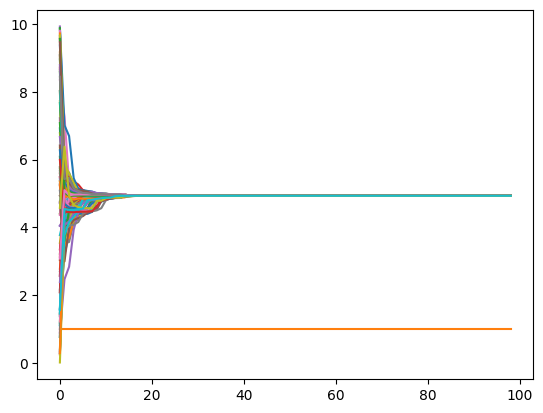

In [194]:
r=consensus(x0, adjacency_matrix, nit=100, attck_vals={1:lambda x:1})

plt.plot(list(range(len(r))),list(r))
plt.show()

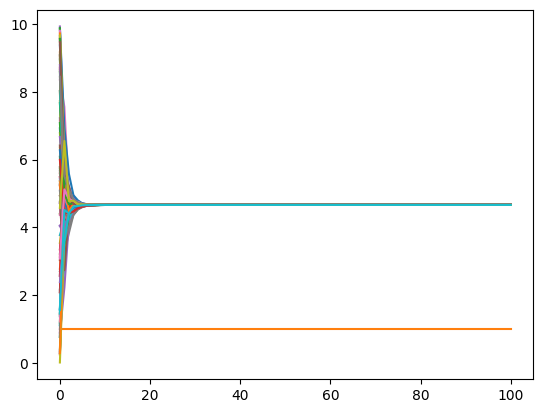

In [195]:
r=msr_consensus(x0, adjacency_matrix, max_iterations=100, attck_vals={1:lambda x:1}, f=1)
plt.plot(list(range(len(r))),list(r))
plt.show()

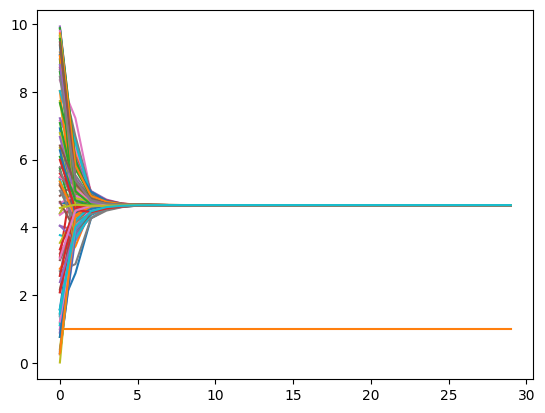

In [196]:
r=repBasedConsensus(x0, adjacency_matrix, max_iterations=30, attck_vals={1:lambda x:1}, f=1)
plt.plot(list(range(len(r))),list(r))
plt.show()

In [202]:
%timeit consensus(x0, adjacency_matrix, nit=100, attck_vals={1:lambda x:1})

1.65 s ± 22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [203]:
%timeit msr_consensus(x0, adjacency_matrix, max_iterations=100, attck_vals={0:lambda x:1})

96.9 ms ± 958 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [204]:
%timeit repBasedConsensus(x0, adjacency_matrix, max_iterations=100, attck_vals={0:lambda x:1})

267 ms ± 24.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
